# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [4]:
PROJECT = 'voltaic-syntax-421118'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION
!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = dimin1886@gmail.com
project = voltaic-syntax-421118
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [5]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://voltaic-syntax-421118-storage/...
ServiceException: 409 A Cloud Storage bucket named 'voltaic-syntax-421118-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [6]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [7]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [8]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [9]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))

GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [10]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [11]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

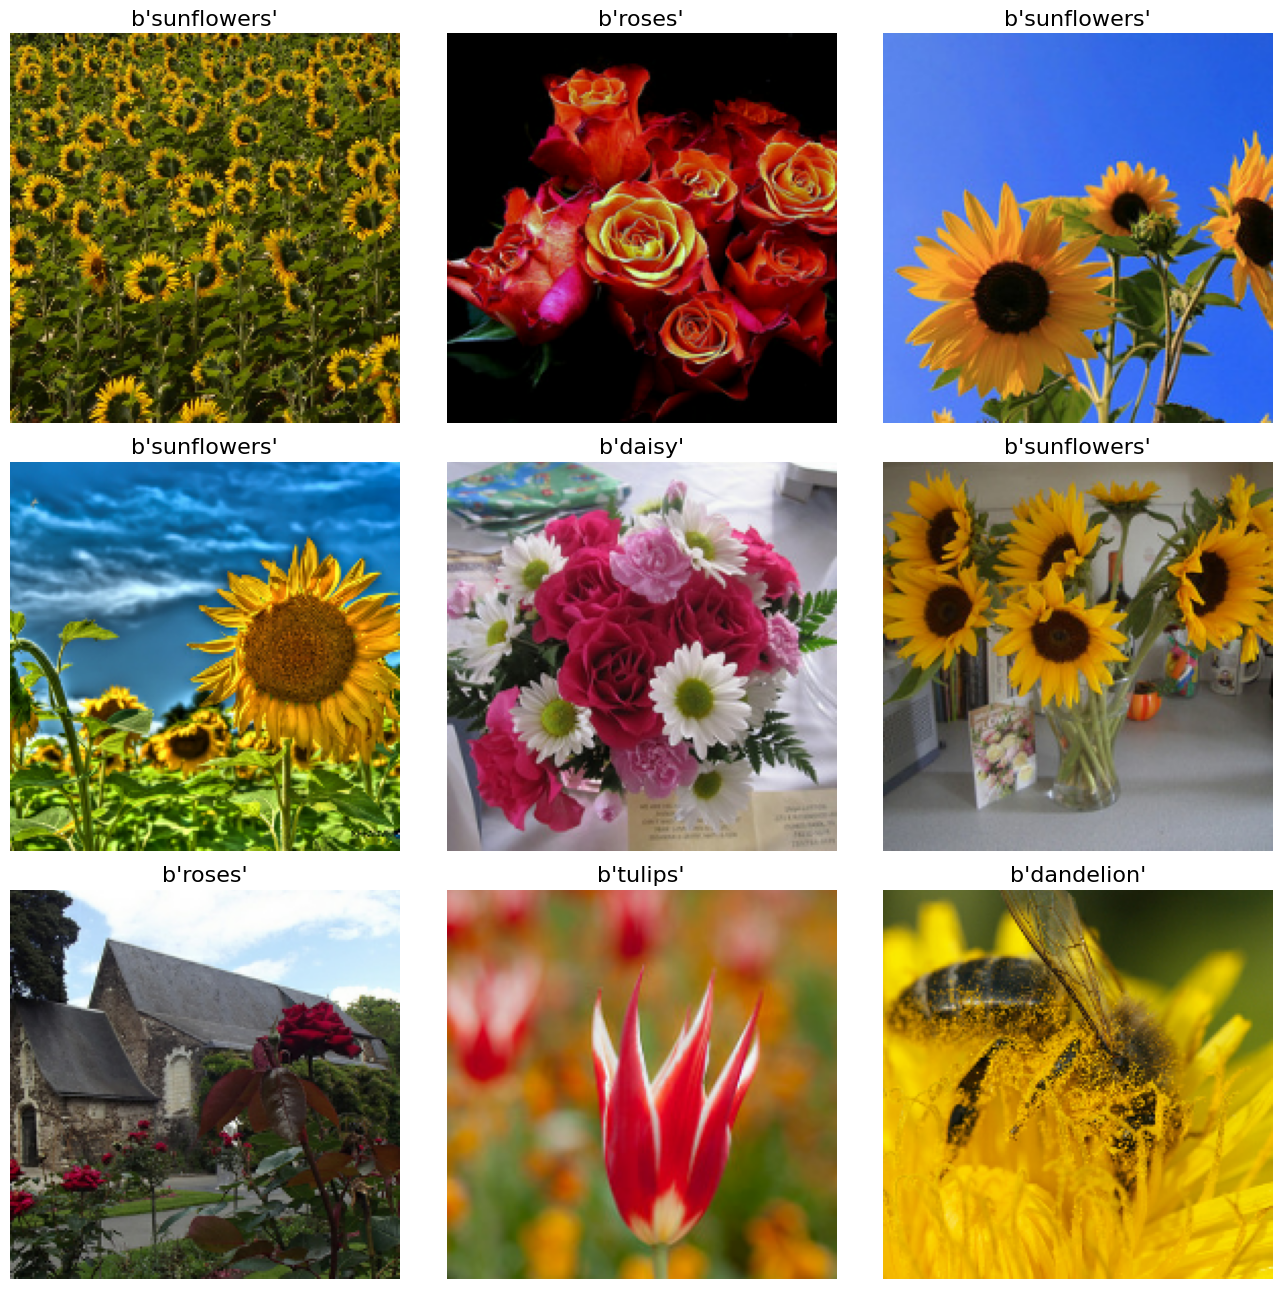

In [12]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [13]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['dandelion', 'tulips', 'tulips', 'roses', 'sunflowers', 'daisy', 'sunflowers', 'tulips', 'roses', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'daisy', 'tulips', 'daisy', 'dandelion', 'tulips', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['roses', 'tulips', 'roses', 'tulips', 'dandelion', 'roses', 'dandelion', 'daisy', 'roses', 'tulips'])
Image batch shape (10, 192, 192, 3), ['daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'sunflowers', 'tulips', 'roses', 'daisy', 'roses'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'dandelion', 'daisy', 'tulips', 'daisy', 'tulips', 'daisy', 'dandelion', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'roses', 'dandelion', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'tulips', 'tulips', 'roses', 'tulips', 'daisy', 'roses', 'daisy', 

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [14]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'tulips', 'tulips', 'sunflowers', 'tulips', 'sunflowers'])
Image batch shape (10,), ['roses', 'roses', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'roses', 'tulips', 'sunflowers', 'dandelion'])
Image batch shape (10,), ['sunflowers', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'roses', 'sunflowers'])
Image batch shape (10,), ['sunflowers', 'tulips', 'tulips', 'daisy', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'roses'])
Image batch shape (10,), ['tulips', 'roses', 'daisy', 'tulips', 'roses', 'dandelion', 'roses', 'sunflowers', 'sunflowers', 'dandelion'])
Image batch shape (10,), ['dandelion', 'tulips', 'daisy', 'sunflowers', 'tulips', 'roses', 'daisy', 'sunflowers', 'tulips', 'dandelion'])
Image batch shape (10,), ['dandelion', 'dandelion', 'dandelion', 'tulips', 'daisy', 'dandelion', 'roses', 'sunflowers', 'roses', 'daisy'])
Image batch 

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [15]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [16]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [17]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [18]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [19]:
import os, sys, math# Importing the operating system, the system and the math modules.
import numpy as np# Importing numpy for mathematical operations.
import scipy as sp# Importing scipy for scientific computations.
import scipy.stats# From scipy, importing stats for statistical operations.
import time# Importing time for operations that involve time measurements.
import string# Importing string operations.
import datetime# Importing datetime for measurements involving time and date.
import random# Importing the random module.
from matplotlib import pyplot as plt# Importing matplotlib for the creation of graphical represantations.
import tensorflow as tf# importing tensorflow for machine learning operations.
print("Tensorflow version " + tf.__version__)# Printing the tensorflow version.
import pickle# Importing pickle for saving the best models.
import pyspark# Importing pyspark for distributed computing.
from pyspark.sql import SQLContext# Improrting SQLContext for manipulating spark SQL.
from pyspark.sql import Row# Importing Row for spark dataframes.
from pyspark.sql import SparkSession# Importing SparkSession to manage the spark operations.

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern to obtain the flower images.
PROJECT = 'voltaic-syntax-421118'# Project ID for using the Google cloud storage.
BUCKET = 'gs://{}-storage'.format(PROJECT)# Defining the url for the GCS bucket.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'# The output path for the GCS.
PARTITIONS = 16# Number of partitions for the spark operations.
TARGET_SIZE = [192, 192]# Target size for images.

# Task 1a
# i) Copy over the mapping functions and adapt the resizing and recompression functions to Spark (only one argument).
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)# Reading the file as a tensor.
    image = tf.image.decode_jpeg(bits)# Decoding the JPEG image.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Splitting the filepath to obtain the image label.
    label2 = label.values[-2]# Obtaining the second to last value as a label
    return image, label2# Returning the decoded image and it's label

def resize_and_crop_image(data):
    image, label = data# Defining the image and label as data, to be used as one argument in the function.
    w = tf.shape(image)[0]# Obtaining the image width.
    h = tf.shape(image)[1]# Obtaining the image height.
    tw = TARGET_SIZE[1] #Target width.
    th = TARGET_SIZE[0] #Target height.
    resize_crit = (w * th) / (h * tw)# Decision on the resizing criteria.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),# Resizing the image based on the width.
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])# Resizing the image based on the height.
                    )
    nw = tf.shape(image)[0]# The new image after resizing based on width.
    nh = tf.shape(image)[1]# The new image after resizing based on height.
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)# Cropping the image to center and target size.
    return (image, label)# Returning the new image and label as a tuple.

def recompress_image(data):
    image, label = data# Defining the image and label as data, to be used as one argument in the function.
    image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)# Encoding the image back to JPEG format.
    return (image, label)# Returning the new image and label as a tuple.

Tensorflow version 2.15.0


In [20]:
# ii)  Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
sc = pyspark.SparkContext.getOrCreate()# Get or create a SparkContext.
spark = SparkSession.builder.getOrCreate()# Get or create a SparkSession.

image_paths = tf.io.gfile.glob(GCS_PATTERN)# Obtaining the list of image filenames that match the pattern.
image_rdd = sc.parallelize(image_paths)# Creating an RDD from the list.

In [21]:
# iii) Sample the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.
sample_factor = 0.02# Defining the sample factor.
rdd1_sample = image_rdd.sample(False, sample_factor)# Creating a sampled RDD with a factor of 0.02.
rdd2_decode_jpeg_and_label = image_rdd.map(decode_jpeg_and_label)# Mapping the image_rdd to decode the JPEG and the label.
rdd3_resize_and_crop_image = rdd2_decode_jpeg_and_label.map(resize_and_crop_image)# Resizing and cropping the image from rdd2.
rdd4_recompress_image = rdd3_resize_and_crop_image.map(recompress_image)# Recompressing the image from rdd3.

In [22]:
# iv) Then use the functions from above to write the TFRecord files.
def _bytestring_feature(list_of_bytestrings):# Creating a tensorflow feature from the list of byte strings.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):# Creating a tensorflow feature from the list of integers.
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label):# Creating a TFRecord from the image bytes and labels.
    class_num = np.argmax(np.array(CLASSES)==label)# Obtaining the class index for the label.
    one_hot_class = np.eye(len(CLASSES))[class_num]# One-hot encoding for the class.
    feature = {
        "image": _bytestring_feature([img_bytes]),# Adding the string of image bytes as a feature.
        "class": _int_feature([class_num])# Adding the class number as a feature.
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))# Returning the TFRecord example.
print("Writing TFRecords")# Indication of TFRecord writing.

def write_tfrecords(partition_index,partition):# Creating a TFRecord for each partition with spark.
  filename = GCS_OUTPUT + "{}.tfrec".format(partition_index)# Defining the output filename with an index.
  with tf.io.TFRecordWriter(filename) as out_file:# Openning the TFRecord writer for output file.
    for element in partition:# Looping through each element in the partition.
      image=element[0]# Image byte extraction.
      label=element[1]# Label extraction.
      example = to_tfrecord(out_file,
                            image.numpy(),# Converting the image tensor to a numpy array.
                            label.numpy()# Converting the label tensor to a numpy arrary.
                            )
      out_file.write(example.SerializeToString())# Writting the example that was serialized to the file.
  return [filename]# Returning the list of the filenames.

Writing TFRecords


In [23]:
# v)  The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you
#should return the filename, so that you have a list of the created TFRecord files.

rdd5_partitions = rdd4_recompress_image.repartition(PARTITIONS)# Repartioning the RDD to 16.
rdd1_filenames = rdd4_recompress_image.mapPartitionsWithIndex(write_tfrecords)# Indexing each partition.

In [24]:
rdd1_filenames.take(1)# Obtaining the first element from rdd1_filenames.

['gs://voltaic-syntax-421118-storage/tfrecords-jpeg-192x192-2/flowers0.tfrec']

In [25]:
rdd2_decode_jpeg_and_label.take(1)# Obtaining the first element from the decoded JPEG and labels.

[(<tf.Tensor: shape=(263, 320, 3), dtype=uint8, numpy=
  array([[[133, 135, 132],
          [136, 138, 135],
          [140, 142, 139],
          ...,
          [152, 152, 150],
          [155, 155, 153],
          [148, 148, 146]],
  
         [[133, 135, 132],
          [136, 138, 135],
          [140, 142, 139],
          ...,
          [153, 153, 151],
          [155, 155, 153],
          [147, 147, 145]],
  
         [[132, 134, 129],
          [135, 137, 134],
          [139, 141, 138],
          ...,
          [152, 152, 150],
          [154, 154, 152],
          [146, 146, 144]],
  
         ...,
  
         [[ 44,  48,  25],
          [ 44,  48,  25],
          [ 44,  48,  25],
          ...,
          [127, 126, 122],
          [127, 126, 122],
          [127, 126, 122]],
  
         [[ 44,  48,  25],
          [ 44,  48,  25],
          [ 44,  48,  25],
          ...,
          [128, 127, 123],
          [128, 127, 123],
          [128, 127, 123]],
  
         [[ 43,  47,  2

In [26]:
rdd3_resize_and_crop_image.take(1)# Obtaining the first element of the resized and cropped images.

[(<tf.Tensor: shape=(192, 192, 3), dtype=float32, numpy=
  array([[[154.31648 , 158.31648 , 161.31648 ],
          [154.03465 , 158.03465 , 161.03465 ],
          [152.40732 , 156.40732 , 159.40732 ],
          ...,
          [166.26291 , 167.93884 , 169.71353 ],
          [164.40128 , 168.40128 , 169.40128 ],
          [164.      , 168.      , 169.      ]],
  
         [[168.3533  , 172.16167 , 175.54494 ],
          [166.39734 , 170.39734 , 173.39734 ],
          [163.65054 , 167.65054 , 170.65054 ],
          ...,
          [165.4297  , 167.10564 , 168.88033 ],
          [164.40128 , 168.40128 , 169.40128 ],
          [164.      , 168.      , 169.      ]],
  
         [[164.95058 , 168.      , 172.90114 ],
          [163.81895 , 167.81895 , 170.81895 ],
          [162.34184 , 166.34184 , 169.34184 ],
          ...,
          [166.90747 , 167.95851 , 169.9415  ],
          [166.25023 , 167.47679 , 169.40128 ],
          [165.84895 , 167.07552 , 169.      ]],
  
         ...,
  
     

In [27]:
rdd4_recompress_image.take(1)# Obtaining the first element from the recompressed images.

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x06\x07\x03\x02\x01\x08\x00\xff\xc4\x00D\x10\x00\x02\x01\x03\x03\x03\x02\x03\x04\x08\x03\x06\x05\x05\x01\x00\x01\x02\x03\x04\x05\x11\x00\x06\x12\x07!1\x13A"Qa\x142q\x81\x08\x15#BRb\x91\xa1\x16\xb1\xc1\x173r\x82\xd1\xe1CS\x92\xb2\xf0\t$4c\xc2\xf1\xff\xc4\x00\x1c\x01\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00

In [28]:
rdd5_partitions.take(1)# Obtaining the first element from the partitions list.

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x06\x07\x04\x05\x08\x03\x02\t\x00\x01\xff\xc4\x00?\x10\x00\x01\x03\x03\x04\x01\x02\x04\x04\x04\x04\x04\x06\x03\x01\x00\x01\x02\x03\x04\x05\x06\x11\x00\x07\x12!1\x13A\x08\x14"Q\x152aq#B\x81\x91\t\x16\x17\xa13Rb\xb1$C\xc1\xd1\xe1\xf0c\x82\x92\xf1\xff\xc4\x00\x1c\x01\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


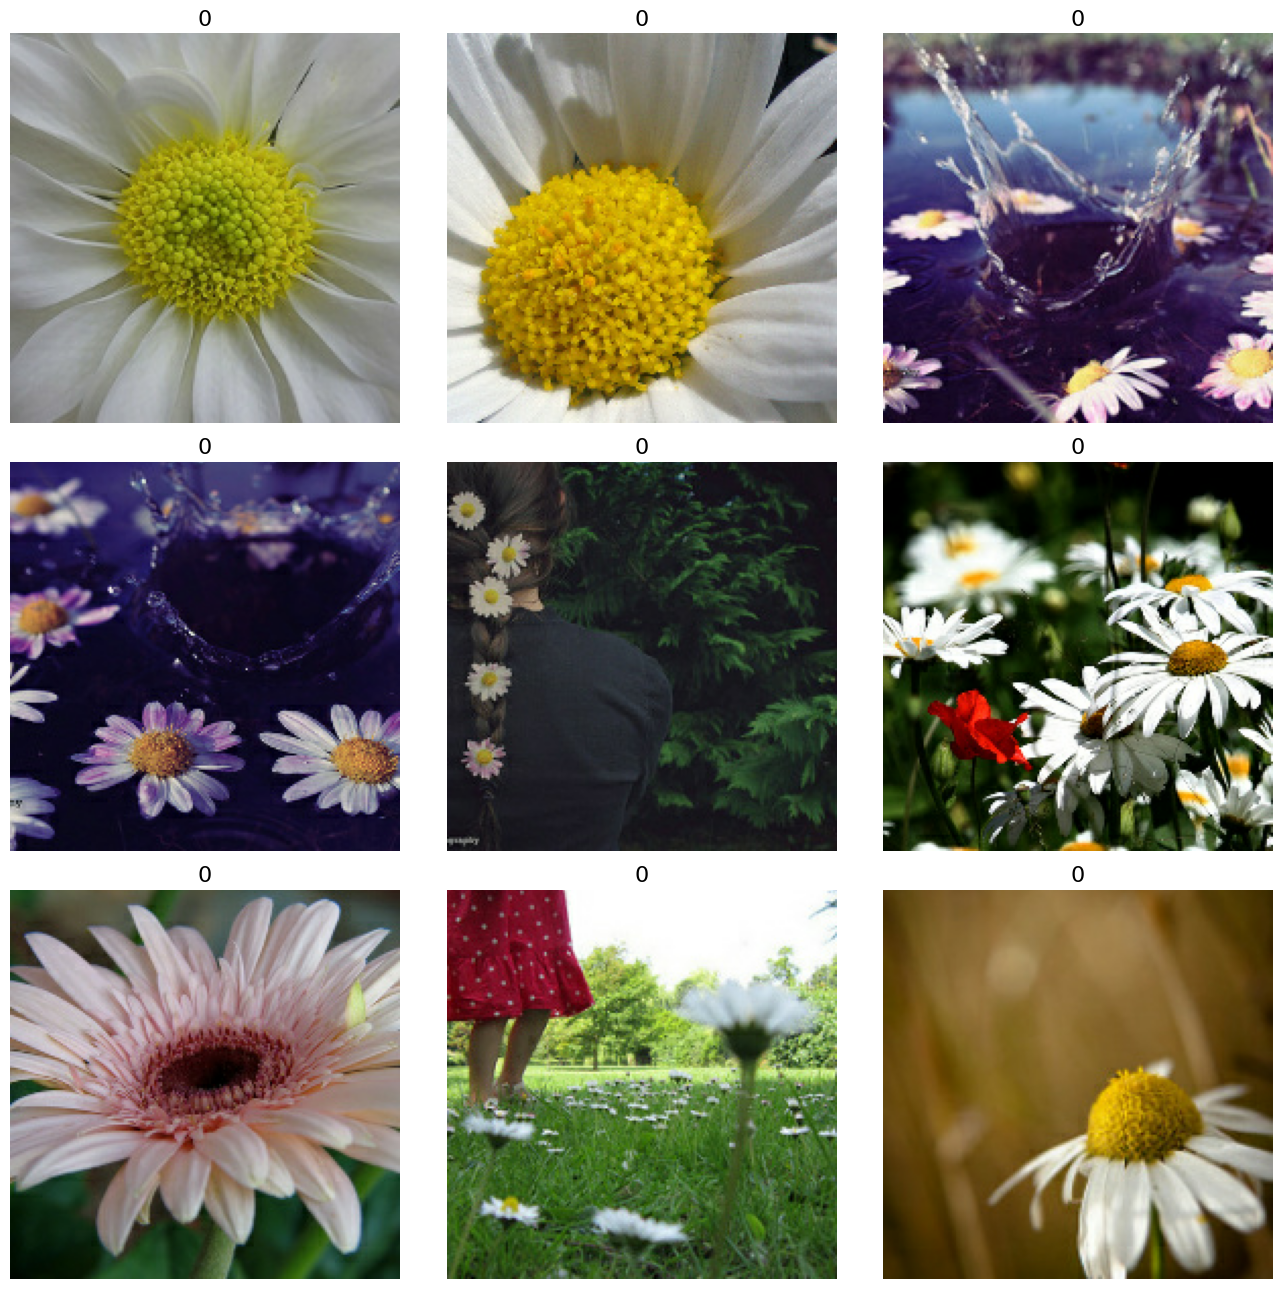

In [29]:
# Task 1
# 1b) Testing (3%)
# i) Read from the TFRecord Dataset, using load_dataset and display_9_images_from_dataset to test.
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # We should remove this line to use our own files that we generated above.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
DatasetDec = load_dataset(filenames)
display_9_images_from_dataset(DatasetDec)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [30]:
%%writefile spark_write_tfrec.py
import os, sys, math# Importing the operating system, the system and the math modules.
import numpy as np# Importing numpy for mathematical operations.
#import scipy as sp# Importing scipy for scientific computations.
#import scipy.stats# From scipy, importing stats for statistical operations.
import time# Importing time for operations that involve time measurements.
import string# Importing string operations.
import datetime# Importing datetime for measurements involving time and date.
import random# Importing the random module.
from matplotlib import pyplot as plt# Importing matplotlib for the creation of graphical represantations.
import tensorflow as tf# importing tensorflow for machine learning operations.
print("Tensorflow version " + tf.__version__)# Printing the tensorflow version.
import pickle# Importing pickle for saving the best models.
import pyspark# Importing pyspark for distributed computing.
from pyspark.sql import SQLContext# Improrting SQLContext for manipulating spark SQL.
from pyspark.sql import Row# Importing Row for spark dataframes.
from pyspark.sql import SparkSession# Importing SparkSession to manage the spark operations.

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern to obtain the flower images.
PROJECT = 'voltaic-syntax-421118'# Project ID for using the Google cloud storage.
BUCKET = 'gs://{}-storage'.format(PROJECT)# Defining the url for the GCS bucket.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'# The output path for the GCS.
PARTITIONS = 16# Number of partitions for the spark operations.
TARGET_SIZE = [192, 192]# Target sizes for images.

# Task 1a
# i) Copy over the mapping functions and adapt the resizing and recompression functions to Spark (only one argument).
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)# Reading the file as a tensor.
    image = tf.image.decode_jpeg(bits)# Decoding the JPEG image.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Splitting the filepath to obtain the image label.
    label2 = label.values[-2]# Obtaining the second to last value as a label
    return image, label2# Returning the decoded image and it's label

def resize_and_crop_image(data):
    image, label = data# Defining the image and label as data, to be used as one argument in the function.
    w = tf.shape(image)[0]# Obtaining the image width.
    h = tf.shape(image)[1]# Obtaining the image height.
    tw = TARGET_SIZE[1] #Target width.
    th = TARGET_SIZE[0] #Target height.
    resize_crit = (w * th) / (h * tw)# Decision on the resizing criteria.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),# Resizing the image based on the width.
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])# Resizing the image based on the height.
                    )
    nw = tf.shape(image)[0]# The new image after resizing based on width.
    nh = tf.shape(image)[1]# The new image after resizing based on height.
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)# Cropping the image to center and target size.
    return (image, label)# Returning the new image and label as a tuple.

def recompress_image(data):
    image, label = data# Defining the image and label as data, to be used as one argument in the function.
    image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)# Encoding the image back to JPEG format.
    return (image, label)# Returning the new image and label as a tuple.

# ii)  Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
sc = pyspark.SparkContext.getOrCreate()# Get or create a SparkContext.
spark = SparkSession.builder.getOrCreate()# Get or create a SparkSession.

image_paths = tf.io.gfile.glob(GCS_PATTERN)# Obtaining the list of image filenames that match the pattern.
image_rdd = sc.parallelize(image_paths)# Creating an RDD from the list.

# iii) Sample the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.
sample_factor = 0.02# Defining the sample factor.
rdd1_sample = image_rdd.sample(False, sample_factor)# Creating a sampled RDD with a factor of 0.02.
rdd2_decode_jpeg_and_label = image_rdd.map(decode_jpeg_and_label)# Mapping the image_rdd to decode the JPEG and the label.
rdd3_resize_and_crop_image = rdd2_decode_jpeg_and_label.map(resize_and_crop_image)# Resizing and cropping the image from rdd2.
rdd4_recompress_image = rdd3_resize_and_crop_image.map(recompress_image)# Recompressing the image from rdd3.

# iv) Then use the functions from above to write the TFRecord files.
def _bytestring_feature(list_of_bytestrings):# Creating a tensorflow feature from the list of byte strings.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):# Creating a tensorflow feature from the list of integers.
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label):# Creating a TFRecord from the image bytes and labels.
    class_num = np.argmax(np.array(CLASSES)==label)# Obtaining the class index for the label.
    one_hot_class = np.eye(len(CLASSES))[class_num]# One-hot encoding for the class.
    feature = {
        "image": _bytestring_feature([img_bytes]),# Adding the string of image bytes as a feature.
        "class": _int_feature([class_num])# Adding the class number as a feature.
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))# Returning the TFRecord example.
print("Writing TFRecords")# Indication of TFRecord writing.

def write_tfrecords(partition_index,partition):# Creating a TFRecord for each partition with spark.
  filename = GCS_OUTPUT + "{}.tfrec".format(partition_index)# Defining the output filename with an index.
  with tf.io.TFRecordWriter(filename) as out_file:# Openning the TFRecord writer for output file.
    for element in partition:# Looping through each element in the partition.
      image=element[0]# Image byte extraction.
      label=element[1]# Label extraction.
      example = to_tfrecord(out_file,
                            image.numpy(),# Converting the image tensor to a numpy array.
                            label.numpy()# Converting the label tensor to a numpy arrary.
                            )
      out_file.write(example.SerializeToString())# Writting the example that was serialized to the file.
  return [filename]# Returning the list of the filenames.

# v)  The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you
#should return the filename, so that you have a list of the created TFRecord files.

rdd5_partitions = rdd4_recompress_image.repartition(PARTITIONS)# Repartioning the RDD to 16.
rdd1_filenames = rdd4_recompress_image.mapPartitionsWithIndex(write_tfrecords)# Indexing each partition.

# Task 1
# 1b) Testing (3%)
# i) Read from the TFRecord Dataset, using load_dataset and display_9_images_from_dataset to test.
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # We should remove this line to use our own files that we generated above.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
DatasetDec = load_dataset(filenames)
display_9_images_from_dataset(DatasetDec)

Writing spark_write_tfrec.py


Tensorflow version 2.15.0
Writing TFRecords


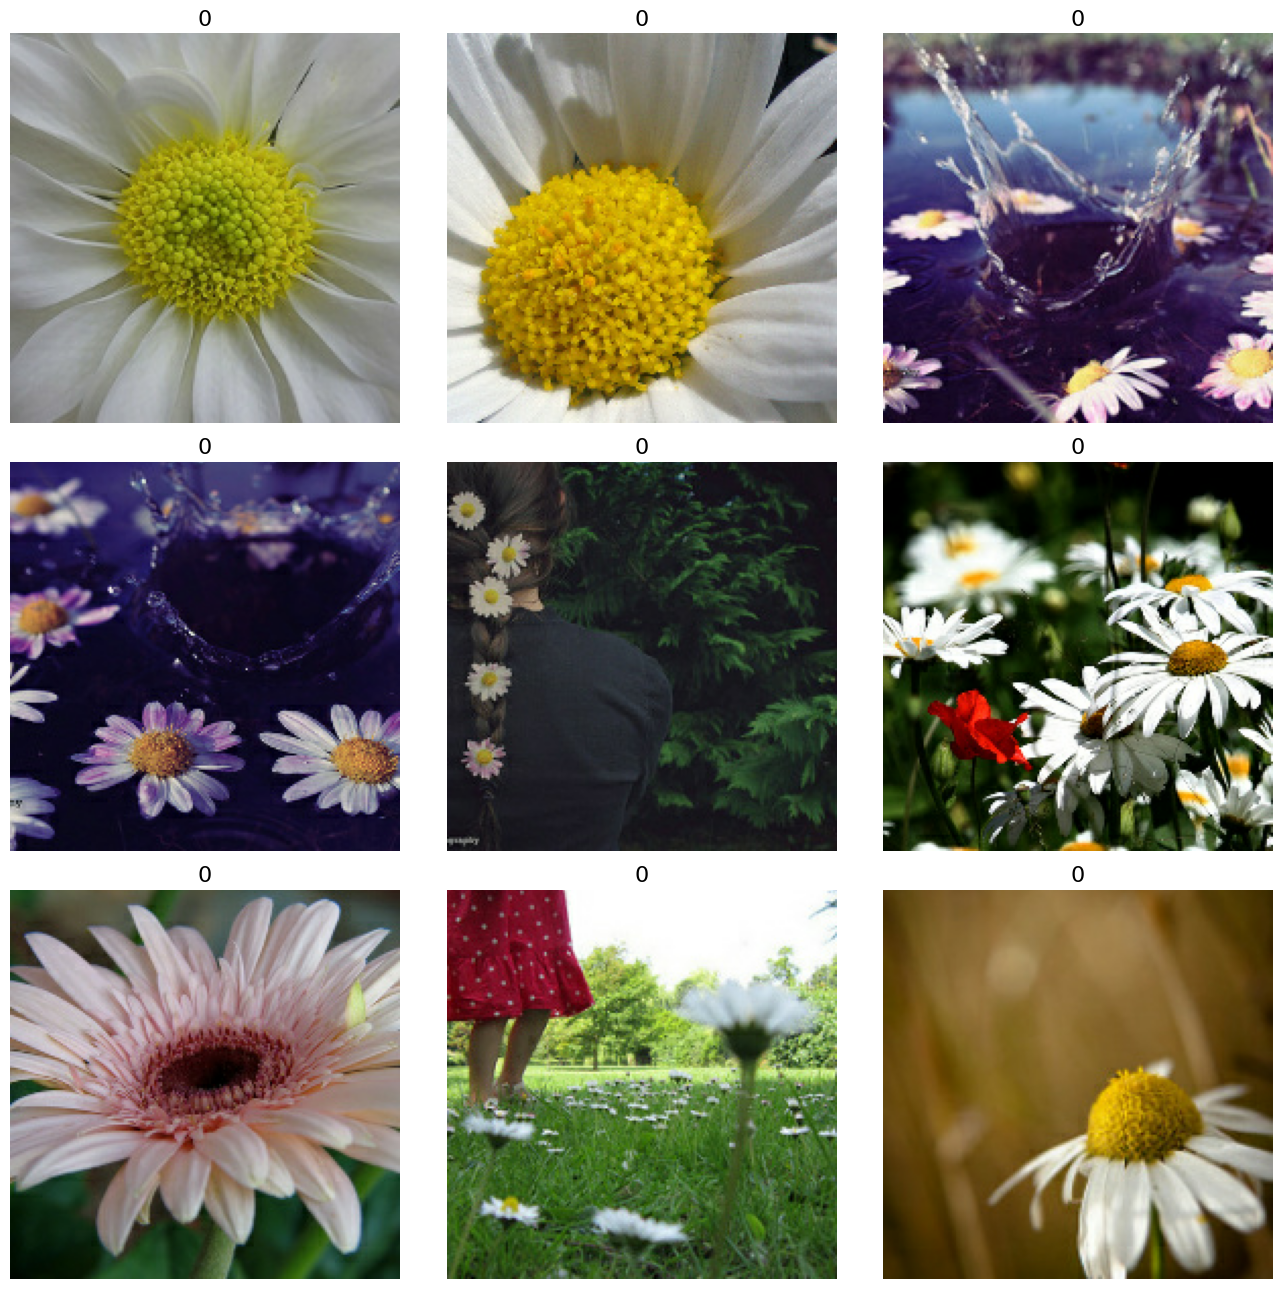

<Figure size 640x480 with 0 Axes>

In [31]:
%run spark_write_tfrec.py

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
# Creating a single machine cluster in Google Cloud using the maximal SSD size (100) and 8vCPUs.
CLUSTER = '{}-singlemachinecluster'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0
## https://spark.apache.org/docs/latest/cluster-overview.html

In [ ]:
!gcloud dataproc clusters describe $CLUSTER --region $REGION# This code is printing information about the cluster that was created above.

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec.py
%time
# Submitting the python script that was created in exercise 1b, as a pyspark job to the cluster created. This job contains, the code written for the image pre-processing.

In [ ]:
CLUSTER = '{}-singlemachinecluster'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
# Deleting the cluster, due to limited quota which does not allow for the many clusters with different configurations to run simultaneously, this will be done for every cluster. The clusters are
# deleted after the each task is completed successfully and the results obtained.

Run the script in the cloud and test the output.

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
# Creating a single machine cluster in Google Cloud using the maximal SSD size (100), 7 worker nodes and 1vCPU for each node.
CLUSTER = '{}-maximalcluster'.format(PROJECT)
REGION = 'us-central1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0
# An error message pops up when this code runs, indicating that not enough resources are available to fulfill this request.

In [ ]:
# Since the cluster above could not be created, another cluster with the maximal SSD size (100), 3 worker nodes and 1vCPU for each node is created instead.
CLUSTER = '{}-maximalcluster2'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 3 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec.py
%time
# Running the script in the cloud and again submitting the script as a pyspark job in Google Cloud.

In [ ]:
CLUSTER = '{}-maximalcluster2'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
# Deleting the cluster to save space for quota purposes.

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
# i) Improve parallelisation
# If you implemented a straightfoward version, you will probably observe that all the computation is done on only two nodes. This can be adressed by using the second parameter in the initial call to parallelize.
# Make the suitable change in the code you have written above and mark it up in comments as ### TASK 1d ###.
# Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with screenshots from Google Cloud and measure the difference in the processing time (6%).

CLUSTER = '{}-7workerscluster'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0
    # Creating a cluster with 8 machines, which includes 1 master node with 7 worker nodes and a type n-1 machine with a maximal SSD size (100).

In [ ]:
pip install protobuf==3.20.* # Protobuf is installed to serialize structured daata.

In [32]:
%%writefile task1d.py
import os, sys, math# Importing the operating system, the system and the math modules.
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np# Importing numpy for mathematical operations.
#import scipy as sp# Importing scipy for scientific computations.
#import scipy.stats# From scipy, importing stats for statistical operations.
import time# Importing time for operations that involve time measurements.
import string# Importing string operations.
import datetime# Importing datetime for measurements involving time and date.
import random# Importing the random module.
#from matplotlib import pyplot as plt# Importing matplotlib for the creation of graphical represantations.
import tensorflow as tf# importing tensorflow for machine learning operations.
print("Tensorflow version " + tf.__version__)# Printing the tensorflow version.
import pickle# Importing pickle for saving the best models.
import pyspark# Importing pyspark for distributed computing.
from pyspark.sql import SQLContext# Improrting SQLContext for manipulating spark SQL.
from pyspark.sql import Row# Importing Row for spark dataframes.
from pyspark.sql import SparkSession# Importing SparkSession to manage the spark operations.

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern to obtain the flower images.
PROJECT = 'voltaic-syntax-421118'# Project ID for using the Google cloud storage.
BUCKET = 'gs://{}-storage'.format(PROJECT)# Defining the url for the GCS bucket.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'# The output path for the GCS.
PARTITIONS = 16# Number of partitions for the spark operations.
TARGET_SIZE = [192, 192]# Target sizes for images.
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']# Image classes.

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)# Reading the file as a tensor.
    image = tf.image.decode_jpeg(bits)# Decoding the JPEG image.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Splitting the filepath to obtain the image label.
    label2 = label.values[-2]# Obtaining the second to last value as a label
    return image, label2# Returning the decoded image and it's label

def resize_and_crop_image(data):
    image, label = data# Defining the image and label as data, to be used as one argument in the function.
    w = tf.shape(image)[0]# Obtaining the image width.
    h = tf.shape(image)[1]# Obtaining the image height.
    tw = TARGET_SIZE[1] #Target width.
    th = TARGET_SIZE[0] #Target height.
    resize_crit = (w * th) / (h * tw)# Decision on the resizing criteria.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),# Resizing the image based on the width.
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])# Resizing the image based on the height.
                    )
    nw = tf.shape(image)[0]# The new image after resizing based on width.
    nh = tf.shape(image)[1]# The new image after resizing based on height.
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)# Cropping the image to center and target size.
    return (image, label)# Returning the new image and label as a tuple.

def recompress_image(data):
    image, label = data# Defining the image and label as data, to be used as one argument in the function.
    image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)# Encoding the image back to JPEG format.
    return (image, label)# Returning the new image and label as a tuple.

# ii)  Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
sc = pyspark.SparkContext.getOrCreate()# Get or create a SparkContext.
spark = SparkSession.builder.getOrCreate()# Get or create a SparkSession.

image_paths = tf.io.gfile.glob(GCS_PATTERN)# Obtaining the list of image filenames that match the pattern.

### Task 1d ###

image_rdd = sc.parallelize(image_paths, 16)# Creating an RDD from the filenames list with 16 partitions.

sample_factor = 0.02# Defining the sample factor.
rdd1_sample = image_rdd.sample(False, sample_factor)# Creating a sampled RDD with a factor of 0.02.
rdd2_decode_jpeg_and_label = image_rdd.map(decode_jpeg_and_label)# Mapping the image_rdd to decode the JPEG and the label.
rdd3_resize_and_crop_image = rdd2_decode_jpeg_and_label.map(resize_and_crop_image)# Resizing and cropping the image from rdd2.
rdd4_recompress_image = rdd3_resize_and_crop_image.map(recompress_image)# Recompressing the image from rdd3.

print("Writing TFRecords")# Indication of TFRecord writing.

def write_tfrecords(partition_index,partition):# Creating a TFRecord for each partition with spark.
  filename = GCS_OUTPUT + "{}.tfrec".format(partition_index)# Defining the output filename with an index.
  with tf.io.TFRecordWriter(filename) as out_file:# Openning the TFRecord writer for output file.
    for element in partition:# Looping through each element in the partition.
      image=element[0]# Image byte extraction.
      label=element[1]# Label extraction.
      example = to_tfrecord(out_file,
                            image.numpy(),# Converting the image tensor to a numpy array.
                            label.numpy()# Converting the label tensor to a numpy arrary.
                            )
      out_file.write(example.SerializeToString())# Writting the example that was serialized to the file.
  return [filename]# Returning the list of the filenames.

# v)  The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you
#should return the filename, so that you have a list of the created TFRecord files.

rdd5_partitions = rdd4_recompress_image.repartition(PARTITIONS)# Repartioning the RDD to 16.
rdd1_filenames = rdd4_recompress_image.mapPartitionsWithIndex(write_tfrecords)# Indexing each partition.

Writing task1d.py


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./task1d.py
%time
# Submitting the job for the cluster that was created above.

In [ ]:
CLUSTER = '{}-7workerscluster'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
# Deleting the cluster created due to quota reasons.

In [ ]:
# ii) Experiment with cluster configurations.
# In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
# Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud (7%).

CLUSTER = '{}-task1dcluster-3workers'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 --worker-machine-type n1-standard-2 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0
# The cluster created above has 1 master node, 3 worker nodes of type n-2 and the maximal SSD size (100).

In [ ]:
CLUSTER = '{}-task1dcluster-3workers'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./task1d.py
%time
# Submitting the job for the cluster created.

In [ ]:
CLUSTER = '{}-task1dcluster-3workers'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
# Deleting the cluster due to limited quota reasons.

In [ ]:
CLUSTER = '{}-task1dcluster-0workers'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0
# The cluster created above has 1 master node and 0 worker nodes with a maximal SSD size (100).

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./task1d.py
%time
# Submitting the job for the cluster created above.

In [ ]:
CLUSTER = '{}-task1dcluster-0workers'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
# Deleting the cluster due to quota reasons.

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [33]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [34]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'daisy'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'tulips'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'tulips'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'dandelion'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image ba

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [35]:
#i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%).
import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

def read_tfrecord(record):# Define and parse the TFRecord features for the image data.
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),# Defining images as a string feature.
        "class": tf.io.FixedLenFeature([], tf.int64)# Defining class as an integer feature.
    }
    example = tf.io.parse_single_example(record, feature_description)# Parsing the example using the feautures defined above.
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)# Decoding the JPEG image.
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])# Reshaping the image to the target size dimensions.
    class_label = example['class']# Extracting the class label from the example.
    return image_reshaped, class_label# Returning the reshaped images and labels.

def load_dataset(filenames):# Loading a dataset from TFRecords file.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False # Setting this to false means that the files will be loaded in a non-deterministic order.
    dataset = tf.data.TFRecordDataset(filenames)# Creating a dataset from the given filenames.
    dataset = dataset.with_options(option_no_order)# Applying a non-determenistic loading option that were set beforehand.
    dataset_new = dataset.map(read_tfrecord)# Mapping the dataset through the read functions from above.
    return dataset_new# Returning the new processed dataset.

def decode_jpeg_and_label(filepath):# Decoding the JPEG file and extracting the label from the filepath.
    image_data = tf.io.read_file(filepath)# Reading the file.
    decoded_image = tf.image.decode_jpeg(image_data)# Decoding the JPEG file.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Extracting the label from the filepath.
    class_label = label.values[-2]# Selecting the second element from the end as the class label.
    return decoded_image, class_label

def resize_and_crop_image(image, label):# Resizing and cropping an image to the target size whilst maintaining the aspect ratio.
    image_width = tf.shape(image)[0]# Getting the image width.
    image_height = tf.shape(image)[1]# Getting the image length.
    target_width = TARGET_SIZE[1]# Target width.
    target_height = TARGET_SIZE[0]# Target height.
    resize_crit = (image_width * target_height) / (image_height * target_width)# Calculation of the resizing criterion.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    # Resizing the image based on the calculated resizing criterion.
    new_width = tf.shape(image)[0]# New width.
    new_height = tf.shape(image)[1]# New height.
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)# Cropping the resized image.
    return image, label# Returning the new resized image and label.

def recompress_image(image, label):# Recompressingan image into JPEG format.
    uint8_image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)# Encoding the image in JPEG format.
    return jpeg_image, label# Returning the label and the image in JPEG format.

def load_image_jpeg_dataset():# Loading and preprocessing JPEG images from the Google Cloud Storage.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern for the flower images.
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)# Creating a dataset of filepaths.
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)# Decoding images and extracting labels.
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)# Resizing and cropping images.
    image_jpeg_dataset = resized_dataset.map(recompress_image)# Recompressing images into JPEG format.
    return image_jpeg_dataset# Returning the dataset created.

def parameter_combinations(batch_sizes, batch_numbers, repetitions):# Generating parameter combinations.
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))# Returning the parameter combinations.

In [36]:
#ii) Get a Spark context and create the dataset and run timing test for each combination in parallel (2%).
sc = SparkContext.getOrCreate()# Getting or creating a new SparkContext.
batch_sizes = [2, 4, 6]# Defining the batch sizes, for the processing tests.
batch_numbers = [3, 6, 9, 12]# Defining the number of batches, in each processing test.
repetitions = [1, 2, 3]# Defining the number of times, each test will be repeated.

parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions))# Parallelizing the parameter combinations into an RDD.

def time_configs(batch_config):# Function measuring the speed that the TFRecord dataset is processed.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    TRF_dataset = load_dataset(filenames)# Loading the TFRecord dataset from the filenames specified.
    results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for test repetition
        start_time = time.time()# Starting the timer.
        for _ in TRF_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken.
        images_per_second = (batch_size * batch_number) / total_time# Calculation of the number of images processed per second.
        results.append(('TFRecord', batch_config, images_per_second))# Appending the results.
    return results# Return the results of the tests.

def image_configs(batch_config):# Function measuring the speed of the JPEG image dataset.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    img_dataset = load_image_jpeg_dataset()# Loading the JPEG image dataset.
    image_processing_results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for the test repetition.
        start_time = time.time()# Starting the timer.
        for _ in img_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken for the tests to be completed.
        images_per_second = (batch_size * batch_number) / total_time# Calculating the number of images that are processed per second.
        image_processing_results.append(('Image', batch_config, images_per_second))# Appending the results.
    return image_processing_results# Returning the results for this test.

resulting_rdd = parameters_rdd.flatMap(time_configs)# Applying time_configs function to each element in parameters_rdd and flattening the result.
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)# Applying image_configs function to each element in parameters_rdd and flattening the result.

In [37]:
# iii) Transform the resulting RDD to the structure (parameter_combination, images_per_second) and save these values in an array (2%).
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)# Unionising to obtain the combined results for the experiments.
final_results = results_rdd_combined.collect()# Collecting all results into a list.

print('Combined Results:')# Printing a header for the results.
for result in final_results:# For loop to print multiple lines containing the results.
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per sec: {result[2]}')

Combined Results:
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 1), Average Images per sec: 4.541593607724553
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per sec: 17.411505539119773
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per sec: 9.08891495668957
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per sec: 28.142136339237787
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per sec: 34.84509429259782
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per sec: 17.874559010393398
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 1), Average Images per sec: 36.817842865450665
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 2), Average Images per se

In [38]:
# iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (2%).
def param_results(index_param):# Extracting a specified parameter from the results and pairing it with images per second.
    return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

rdd_batch_size = param_results(0)# Extracting the batch size results.
rdd_batch_number = param_results(1)# Extracting the batch number results.
rdd_repetition = param_results(2)# Extracting the repetition results.

def average_images_per_second(data):# Calculating the average images per second from the grouped data.
    total_images = sum(images for images in data)# Summing all images per second values.
    count = len(data)# Counting the number of entries.
    return total_images / count# Returning the average images per second

# Grouping the results by batch size, batch number, and repetition, then calculating the average images per second.
average_batch_size_results = rdd_batch_size.groupByKey().mapValues(average_images_per_second).collect()
average_batch_number_results = rdd_batch_number.groupByKey().mapValues(average_images_per_second).collect()
average_repetition_results = rdd_repetition.groupByKey().mapValues(average_images_per_second).collect()

# Printing the average images per second for each parameter.
print("Average Images per sec for each Batch Size (Batch_Size: average_images_per_sec):", average_batch_size_results)
print("Average Images per sec for each Batch Number (Batch_Number: average_images_per_sec):", average_batch_number_results)
print("Average Images per sec for each Repetition (Repetition: average_images_per_sec):", average_repetition_results)

Average Images per sec for each Batch Size (Batch_Size: average_images_per_sec): [(4, 59.66051315192825), (2, 33.204707081977524), (6, 106.93198362722329)]
Average Images per sec for each Batch Number (Batch_Number: average_images_per_sec): [(12, 97.33374877796045), (9, 77.95274565510562), (6, 54.68982575594459), (3, 26.329943546269458)]
Average Images per sec for each Repetition (Repetition: average_images_per_sec): [(1, 60.097980141349375), (2, 65.24655064076175), (3, 64.41558831609912)]


In [39]:
# v) Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average (3%).
def sequence_op(accumulator, value):# Creating a sequential operation function, that updates the accumulator by adding the new value to the sum (first element of the tuple),
# and is adding to the count (second element of the tuple) by one.
    return (accumulator[0] + value, accumulator[1] + 1)# Returning the output.

def combine_op(accumulator1, accumulator2):# Creating a function that combines the ouputs of the sequantial operation function.
    return (accumulator1[0] + accumulator2[0], accumulator1[1] + accumulator2[1])# Returning the result.

def average_assoc(rdd_parameters):# Creating a function which calculates the average for the associative aggregations.
    return rdd_parameters.aggregateByKey((0, 0), sequence_op, combine_op).mapValues(lambda x: x[0] / x[1]).collect()# Returning the result of the function.

average_batch_size = average_assoc(rdd_batch_size)# Computing the average images per second, grouped by batch size.
average_batch_number = average_assoc(rdd_batch_number)# Computing the average images per second, grouped by batch number.
average_repetition = average_assoc(rdd_repetition)# Computing the average images per second, grouped by repetition.

# Printing the average images per second for each parameter using the associative operations.
print("Average Images per sec for each Each Batch Size (Associativity), (Batch_Size: average_images_per_sec):", average_batch_size)
print("Average Images per sec for each Batch Number (Associativity), (Batch_Number: average_images_per_sec):", average_batch_number)
print("Average Images per sec for each Repetition (Associativity), (Repetition: average_images_per_sec):", average_repetition)

Average Images per sec for each Each Batch Size (Associativity), (Batch_Size: average_images_per_sec): [(4, 68.0054220696908), (2, 32.20348390528295), (6, 96.7286608428304)]
Average Images per sec for each Batch Number (Associativity), (Batch_Number: average_images_per_sec): [(12, 91.06074644071705), (9, 70.42758184075113), (6, 44.899251494897015), (3, 23.51903316986899)]
Average Images per sec for each Repetition (Associativity), (Repetition: average_images_per_sec): [(1, 64.90533063746155), (2, 64.82368477684149), (3, 66.80669879536511)]


In [42]:
pip install google-cloud-storage # Installing the google cloud storage module.

In [43]:
# vi) Write the results to a pickle file in your bucket (2%).
from google.cloud import storage# Importing the storage module to save the results.
import pickle# Importing the pickle module to save the results.

# Creating a dictionary to summarize the results obtained from all the previous tasks.
results_summary = {
    'Final Results from Task iii)': final_results,
    'Average Images per sec by Batch Size from task iv)': average_batch_size_results,
    'Average Images per sec by Batch Number from task iv)': average_batch_number_results,
    'Average Images per sec by Repetition from task iv)': average_repetition_results,
    'Average Images per sec by Batch Size from task v)': average_batch_size,
    'Average Images per sec by Batch Number from task v)': average_batch_number,
    'Average Images per sec by Repetition from task v)': average_repetition
}

pickle_file_path = '/tmp/results_summary.pkl'# Defining the local path where the results will be saved.
with open(pickle_file_path, 'wb') as file:
    pickle.dump(results_summary, file)# Saving the results into a pickle file.

def upload_results_to_cloud(blob_name, local_file_path, bucket_name):# Function to upload the results obtained onto the Google Cloud.
    try:
        gcs_client = storage.Client()# Initializing the google cloud storage client.
        gcs_bucket = gcs_client.get_bucket(bucket_name)# Specifying the GCS bucket.
        gcs_blob = gcs_bucket.blob(blob_name)# Creating a blob (binary large object).
        gcs_blob.upload_from_filename(local_file_path)# Uploading the file to the blob.
        print("Results file uploaded successfully to:", blob_name)# Print this statement if upload is successful.
    except Exception as e:
        print("Failed", e)# Printing this statement if otherwise.

# Using the function created above to upload the results to the cloud.
upload_results_to_cloud('results/results_summary.pkl', pickle_file_path, 'voltaic-syntax-421118-storage')

Results file uploaded successfully to: results/results_summary.pkl


In [44]:
%%writefile spark_job.py
#i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%).
import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'voltaic-syntax-421118'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
TARGET_SIZE = [192,192]
PARTITIONS = 16 # This is the number of partitions that will be used later.

import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

# vii) Write your code it into a file using the cell magic %%writefile spark_job.py (1%).

def read_tfrecord(record):# Define and parse the TFRecord features for the image data.
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),# Defining images as a string feature.
        "class": tf.io.FixedLenFeature([], tf.int64)# Defining class as an integer feature.
    }
    example = tf.io.parse_single_example(record, feature_description)# Parsing the example using the feautures defined above.
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)# Decoding the JPEG image.
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])# Reshaping the image to the target size dimensions.
    class_label = example['class']# Extracting the class label from the example.
    return image_reshaped, class_label# Returning the reshaped images and labels.

def load_dataset(filenames):# Loading a dataset from TFRecords file.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False # Setting this to false means that the files will be loaded in a non-deterministic order.
    dataset = tf.data.TFRecordDataset(filenames)# Creating a dataset from the given filenames.
    dataset = dataset.with_options(option_no_order)# Applying a non-determenistic loading option that were set beforehand.
    dataset_new = dataset.map(read_tfrecord)# Mapping the dataset through the read functions from above.
    return dataset_new# Returning the new processed dataset.

def decode_jpeg_and_label(filepath):# Decoding the JPEG file and extracting the label from the filepath.
    image_data = tf.io.read_file(filepath)# Reading the file.
    decoded_image = tf.image.decode_jpeg(image_data)# Decoding the JPEG file.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Extracting the label from the filepath.
    class_label = label.values[-2]# Selecting the second element from the end as the class label.
    return decoded_image, class_label

def resize_and_crop_image(image, label):# Resizing and cropping an image to the target size whilst maintaining the aspect ratio.
    image_width = tf.shape(image)[0]# Getting the image width.
    image_height = tf.shape(image)[1]# Getting the image length.
    target_width = TARGET_SIZE[1]# Target width.
    target_height = TARGET_SIZE[0]# Target height.
    resize_crit = (image_width * target_height) / (image_height * target_width)# Calculation of the resizing criterion.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    # Resizing the image based on the calculated resizing criterion.
    new_width = tf.shape(image)[0]# New width.
    new_height = tf.shape(image)[1]# New height.
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)# Cropping the resized image.
    return image, label# Returning the new resized image and label.

def recompress_image(image, label):# Recompressingan image into JPEG format.
    uint8_image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)# Encoding the image in JPEG format.
    return jpeg_image, label# Returning the label and the image in JPEG format.

def load_image_jpeg_dataset():# Loading and preprocessing JPEG images from the Google Cloud Storage.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern for the flower images.
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)# Creating a dataset of filepaths.
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)# Decoding images and extracting labels.
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)# Resizing and cropping images.
    image_jpeg_dataset = resized_dataset.map(recompress_image)# Recompressing images into JPEG format.
    return image_jpeg_dataset# Returning the dataset created.

def parameter_combinations(batch_sizes, batch_numbers, repetitions):# Generating parameter combinations.
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))# Returning the parameter combinations.

#ii) Get a Spark context and create the dataset and run timing test for each combination in parallel (2%).
sc = SparkContext.getOrCreate()# Getting or creating a new SparkContext.
batch_sizes = [2, 4, 6]# Defining the batch sizes, for the processing tests.
batch_numbers = [3, 6, 9, 12]# Defining the number of batches, in each processing test.
repetitions = [1, 2, 3]# Defining the number of times, each test will be repeated.

parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions))# Parallelizing the parameter combinations into an RDD.

def time_configs(batch_config):# Function measuring the speed that the TFRecord dataset is processed.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    TRF_dataset = load_dataset(filenames)# Loading the TFRecord dataset from the filenames specified.
    results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for test repetition
        start_time = time.time()# Starting the timer.
        for _ in TRF_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken.
        images_per_second = (batch_size * batch_number) / total_time# Calculation of the number of images processed per second.
        results.append(('TFRecord', batch_config, images_per_second))# Appending the results.
    return results# Return the results of the tests.

def image_configs(batch_config):# Function measuring the speed of the JPEG image dataset.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    img_dataset = load_image_jpeg_dataset()# Loading the JPEG image dataset.
    image_processing_results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for the test repetition.
        start_time = time.time()# Starting the timer.
        for _ in img_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken for the tests to be completed.
        images_per_second = (batch_size * batch_number) / total_time# Calculating the number of images that are processed per second.
        image_processing_results.append(('Image', batch_config, images_per_second))# Appending the results.
    return image_processing_results# Returning the results for this test.

resulting_rdd = parameters_rdd.flatMap(time_configs)# Applying time_configs function to each element in parameters_rdd and flattening the result.
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)# Applying image_configs function to each element in parameters_rdd and flattening the result.


# iii) Transform the resulting RDD to the structure (parameter_combination, images_per_second) and save these values in an array (2%).
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)# Unionising to obtain the combined results for the experiments.
final_results = results_rdd_combined.collect()# Collecting all results into a list.

print('Combined Results:')# Printing a header for the results.
for result in final_results:# For loop to print multiple lines containing the results.
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per sec: {result[2]}')

# iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (2%).
def param_results(index_param):# Extracting a specified parameter from the results and pairing it with images per second.
    return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

rdd_batch_size = param_results(0)# Extracting the batch size results.
rdd_batch_number = param_results(1)# Extracting the batch number results.
rdd_repetition = param_results(2)# Extracting the repetition results.

def average_images_per_second(data):# Calculating the average images per second from the grouped data.
    total_images = sum(images for images in data)# Summing all images per second values.
    count = len(data)# Counting the number of entries.
    return total_images / count# Returning the average images per second

# Grouping the results by batch size, batch number, and repetition, then calculating the average images per second.
average_batch_size_results = rdd_batch_size.groupByKey().mapValues(average_images_per_second).collect()
average_batch_number_results = rdd_batch_number.groupByKey().mapValues(average_images_per_second).collect()
average_repetition_results = rdd_repetition.groupByKey().mapValues(average_images_per_second).collect()

# Printing the average images per second for each parameter.
print("Average Images per sec for each Batch Size (Batch_Size: average_images_per_sec):", average_batch_size_results)
print("Average Images per sec for each Batch Number (Batch_Number: average_images_per_sec):", average_batch_number_results)
print("Average Images per sec for each Repetition (Repetition: average_images_per_sec):", average_repetition_results)

# v) Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average (3%).
def sequence_op(accumulator, value):# Creating a sequential operation function, that updates the accumulator by adding the new value to the sum (first element of the tuple),
# and is adding to the count (second element of the tuple) by one.
    return (accumulator[0] + value, accumulator[1] + 1)# Returning the output.

def combine_op(accumulator1, accumulator2):# Creating a function that combines the ouputs of the sequantial operation function.
    return (accumulator1[0] + accumulator2[0], accumulator1[1] + accumulator2[1])# Returning the result.

def average_assoc(rdd_parameters):# Creating a function which calculates the average for the associative aggregations.
    return rdd_parameters.aggregateByKey((0, 0), sequence_op, combine_op).mapValues(lambda x: x[0] / x[1]).collect()# Returning the result of the function.

average_batch_size = average_assoc(rdd_batch_size)# Computing the average images per second, grouped by batch size.
average_batch_number = average_assoc(rdd_batch_number)# Computing the average images per second, grouped by batch number.
average_repetition = average_assoc(rdd_repetition)# Computing the average images per second, grouped by repetition.

# Printing the average images per second for each parameter using the associative operations.
print("Average Images per sec for each Each Batch Size (Associativity), (Batch_Size: average_images_per_sec):", average_batch_size)
print("Average Images per sec for each Batch Number (Associativity), (Batch_Number: average_images_per_sec):", average_batch_number)
print("Average Images per sec for each Repetition (Associativity), (Repetition: average_images_per_sec):", average_repetition)

# vi) Write the results to a pickle file in your bucket (2%).
from google.cloud import storage# Importing the storage module to save the results.
import pickle# Importing the pickle module to save the results.

# Creating a dictionary to summarize the results obtained from all the previous tasks.
results_summary = {
    'Final Results from Task iii)': final_results,
    'Average Images per sec by Batch Size from task iv)': average_batch_size_results,
    'Average Images per sec by Batch Number from task iv)': average_batch_number_results,
    'Average Images per sec by Repetition from task iv)': average_repetition_results,
    'Average Images per sec by Batch Size from task v)': average_batch_size,
    'Average Images per sec by Batch Number from task v)': average_batch_number,
    'Average Images per sec by Repetition from task v)': average_repetition
}

pickle_file_path = '/tmp/results_summary.pkl'# Defining the local path where the results will be saved.
with open(pickle_file_path, 'wb') as file:
    pickle.dump(results_summary, file)# Saving the results into a pickle file.

def upload_results_to_cloud(blob_name, local_file_path, bucket_name):# Function to upload the results obtained onto the Google Cloud.
    try:
        gcs_client = storage.Client()# Initializing the google cloud storage client.
        gcs_bucket = gcs_client.get_bucket(bucket_name)# Specifying the GCS bucket.
        gcs_blob = gcs_bucket.blob(blob_name)# Creating a blob (binary large object).
        gcs_blob.upload_from_filename(local_file_path)# Uploading the file to the blob.
        print("Results file uploaded successfully to:", blob_name)# Print this statement if upload is successful.
    except Exception as e:
        print("Failed", e)# Printing this statement if otherwise.

# Using the function created above to upload the results to the cloud.
upload_results_to_cloud('results/results_summary.pkl', pickle_file_path, 'voltaic-syntax-421118-storage')

Writing spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [45]:
%run ./spark_job.py # Running the spark job locally.

Combined Results:
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 1), Average Images per sec: 11.300497627714119
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per sec: 17.821874900412514
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per sec: 16.622636561733586
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per sec: 13.697945293836208
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per sec: 15.64203202393746
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per sec: 15.165972925722613
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 1), Average Images per sec: 42.617316983541265
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 2), Average Images per

In [46]:
# Creating a new file
%%writefile spark_job_2b.py
#i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%).
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'voltaic-syntax-421118'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
TARGET_SIZE = [192,192]
PARTITIONS = 16 # This is the number of partitions that will be used later.

import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

# vii) Write your code it into a file using the cell magic %%writefile spark_job.py (1%).

def read_tfrecord(record):# Define and parse the TFRecord features for the image data.
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),# Defining images as a string feature.
        "class": tf.io.FixedLenFeature([], tf.int64)# Defining class as an integer feature.
    }
    example = tf.io.parse_single_example(record, feature_description)# Parsing the example using the feautures defined above.
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)# Decoding the JPEG image.
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])# Reshaping the image to the target size dimensions.
    class_label = example['class']# Extracting the class label from the example.
    return image_reshaped, class_label# Returning the reshaped images and labels.

def load_dataset(filenames):# Loading a dataset from TFRecords file.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False # Setting this to false means that the files will be loaded in a non-deterministic order.
    dataset = tf.data.TFRecordDataset(filenames)# Creating a dataset from the given filenames.
    dataset = dataset.with_options(option_no_order)# Applying a non-determenistic loading option that were set beforehand.
    dataset_new = dataset.map(read_tfrecord)# Mapping the dataset through the read functions from above.
    return dataset_new# Returning the new processed dataset.

def decode_jpeg_and_label(filepath):# Decoding the JPEG file and extracting the label from the filepath.
    image_data = tf.io.read_file(filepath)# Reading the file.
    decoded_image = tf.image.decode_jpeg(image_data)# Decoding the JPEG file.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Extracting the label from the filepath.
    class_label = label.values[-2]# Selecting the second element from the end as the class label.
    return decoded_image, class_label

def resize_and_crop_image(image, label):# Resizing and cropping an image to the target size whilst maintaining the aspect ratio.
    image_width = tf.shape(image)[0]# Getting the image width.
    image_height = tf.shape(image)[1]# Getting the image length.
    target_width = TARGET_SIZE[1]# Target width.
    target_height = TARGET_SIZE[0]# Target height.
    resize_crit = (image_width * target_height) / (image_height * target_width)# Calculation of the resizing criterion.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    # Resizing the image based on the calculated resizing criterion.
    new_width = tf.shape(image)[0]# New width.
    new_height = tf.shape(image)[1]# New height.
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)# Cropping the resized image.
    return image, label# Returning the new resized image and label.

def recompress_image(image, label):# Recompressingan image into JPEG format.
    uint8_image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)# Encoding the image in JPEG format.
    return jpeg_image, label# Returning the label and the image in JPEG format.

def load_image_jpeg_dataset():# Loading and preprocessing JPEG images from the Google Cloud Storage.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern for the flower images.
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)# Creating a dataset of filepaths.
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)# Decoding images and extracting labels.
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)# Resizing and cropping images.
    image_jpeg_dataset = resized_dataset.map(recompress_image)# Recompressing images into JPEG format.
    return image_jpeg_dataset# Returning the dataset created.

def parameter_combinations(batch_sizes, batch_numbers, repetitions):# Generating parameter combinations.
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))# Returning the parameter combinations.

#ii) Get a Spark context and create the dataset and run timing test for each combination in parallel (2%).
sc = SparkContext.getOrCreate()# Getting or creating a new SparkContext.
batch_sizes = [2, 4, 6]# Defining the batch sizes, for the processing tests.
batch_numbers = [3, 6, 9, 12]# Defining the number of batches, in each processing test.
repetitions = [1, 2, 3]# Defining the number of times, each test will be repeated.

parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions))# Parallelizing the parameter combinations into an RDD.

def time_configs(batch_config):# Function measuring the speed that the TFRecord dataset is processed.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    TRF_dataset = load_dataset(filenames)# Loading the TFRecord dataset from the filenames specified.
    results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for test repetition
        start_time = time.time()# Starting the timer.
        for _ in TRF_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken.
        images_per_second = (batch_size * batch_number) / total_time# Calculation of the number of images processed per second.
        results.append(('TFRecord', batch_config, images_per_second))# Appending the results.
    return results# Return the results of the tests.

def image_configs(batch_config):# Function measuring the speed of the JPEG image dataset.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    img_dataset = load_image_jpeg_dataset()# Loading the JPEG image dataset.
    image_processing_results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for the test repetition.
        start_time = time.time()# Starting the timer.
        for _ in img_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken for the tests to be completed.
        images_per_second = (batch_size * batch_number) / total_time# Calculating the number of images that are processed per second.
        image_processing_results.append(('Image', batch_config, images_per_second))# Appending the results.
    return image_processing_results# Returning the results for this test.

resulting_rdd = parameters_rdd.flatMap(time_configs)# Applying time_configs function to each element in parameters_rdd and flattening the result.
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)# Applying image_configs function to each element in parameters_rdd and flattening the result.


# iii) Transform the resulting RDD to the structure (parameter_combination, images_per_second) and save these values in an array (2%).
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)# Unionising to obtain the combined results for the experiments.
final_results = results_rdd_combined.collect()# Collecting all results into a list.

print('Combined Results:')# Printing a header for the results.
for result in final_results:# For loop to print multiple lines containing the results.
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per sec: {result[2]}')

# iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (2%).
def param_results(index_param):# Extracting a specified parameter from the results and pairing it with images per second.
    return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

rdd_batch_size = param_results(0)# Extracting the batch size results.
rdd_batch_number = param_results(1)# Extracting the batch number results.
rdd_repetition = param_results(2)# Extracting the repetition results.

def average_images_per_second(data):# Calculating the average images per second from the grouped data.
    total_images = sum(images for images in data)# Summing all images per second values.
    count = len(data)# Counting the number of entries.
    return total_images / count# Returning the average images per second

# Grouping the results by batch size, batch number, and repetition, then calculating the average images per second.
average_batch_size_results = rdd_batch_size.groupByKey().mapValues(average_images_per_second).collect()
average_batch_number_results = rdd_batch_number.groupByKey().mapValues(average_images_per_second).collect()
average_repetition_results = rdd_repetition.groupByKey().mapValues(average_images_per_second).collect()

# Printing the average images per second for each parameter.
print("Average Images per sec for each Batch Size (Batch_Size: average_images_per_sec):", average_batch_size_results)
print("Average Images per sec for each Batch Number (Batch_Number: average_images_per_sec):", average_batch_number_results)
print("Average Images per sec for each Repetition (Repetition: average_images_per_sec):", average_repetition_results)

# v) Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average (3%).
def sequence_op(accumulator, value):# Creating a sequential operation function, that updates the accumulator by adding the new value to the sum (first element of the tuple),
# and is adding to the count (second element of the tuple) by one.
    return (accumulator[0] + value, accumulator[1] + 1)# Returning the output.

def combine_op(accumulator1, accumulator2):# Creating a function that combines the ouputs of the sequantial operation function.
    return (accumulator1[0] + accumulator2[0], accumulator1[1] + accumulator2[1])# Returning the result.

def average_assoc(rdd_parameters):# Creating a function which calculates the average for the associative aggregations.
    return rdd_parameters.aggregateByKey((0, 0), sequence_op, combine_op).mapValues(lambda x: x[0] / x[1]).collect()# Returning the result of the function.

average_batch_size = average_assoc(rdd_batch_size)# Computing the average images per second, grouped by batch size.
average_batch_number = average_assoc(rdd_batch_number)# Computing the average images per second, grouped by batch number.
average_repetition = average_assoc(rdd_repetition)# Computing the average images per second, grouped by repetition.

# Printing the average images per second for each parameter using the associative operations.
print("Average Images per sec for each Each Batch Size (Associativity), (Batch_Size: average_images_per_sec):", average_batch_size)
print("Average Images per sec for each Batch Number (Associativity), (Batch_Number: average_images_per_sec):", average_batch_number)
print("Average Images per sec for each Repetition (Associativity), (Repetition: average_images_per_sec):", average_repetition)

# vi) Write the results to a pickle file in your bucket (2%).
from google.cloud import storage# Importing the storage module to save the results.
import pickle# Importing the pickle module to save the results.

# Creating a dictionary to summarize the results obtained from all the previous tasks.
results_summary2b = {
    'Final Results from Task iii)': final_results,
    'Average Images per sec by Batch Size from task iv)': average_batch_size_results,
    'Average Images per sec by Batch Number from task iv)': average_batch_number_results,
    'Average Images per sec by Repetition from task iv)': average_repetition_results,
    'Average Images per sec by Batch Size from task v)': average_batch_size,
    'Average Images per sec by Batch Number from task v)': average_batch_number,
    'Average Images per sec by Repetition from task v)': average_repetition
}

pickle_file_path = '/tmp/results_summary.pkl'# Defining the local path where the results will be saved.
with open(pickle_file_path, 'wb') as file:
    pickle.dump(results_summary2b, file)# Saving the results into a pickle file.

def upload_results_to_cloud(blob_name, local_file_path, bucket_name):# Function to upload the results obtained onto the Google Cloud.
    try:
        gcs_client = storage.Client()# Initializing the google cloud storage client.
        gcs_bucket = gcs_client.get_bucket(bucket_name)# Specifying the GCS bucket.
        gcs_blob = gcs_bucket.blob(blob_name)# Creating a blob (binary large object).
        gcs_blob.upload_from_filename(local_file_path)# Uploading the file to the blob.
        print("Results file uploaded successfully to:", blob_name)# Print this statement if upload is successful.
    except Exception as e:
        print("Failed", e)# Printing this statement if otherwise.

# Using the function created above to upload the results to the cloud.
upload_results_to_cloud('results/results_summary2b.pkl', pickle_file_path, 'voltaic-syntax-421118-storage')

Writing spark_job_2b.py


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
# ii) Cloud
# If you have a cluster running, you can run the speed test job in the cloud.
# While you run this job, switch to the Dataproc web page and take screenshots of the CPU and network load over time. They are displayed with some delay,
# so you may need to wait a little. These images will be useful in the next task.
# Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.

CLUSTER = '{}-task2bclustermax7'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib google-cloud-storage==1.42.0 google-api-core==1.31.0 protobuf==3.17.3'
# Creating a cluster consisting of 7 worker nodes and 1 machine with a maximal SSD size (100).

In [ ]:
CLUSTER = '{}-task2bclustermax7'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_job_2b.py
%time
# Submitting the job for the cluster created above.

In [ ]:
CLUSTER = '{}-task2bclustermax7'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
# Due to limited quota reasons, the cluster created above is deleted.

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [47]:
# Creating a new file
%%writefile spark_job_2c.py
#i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%).
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'voltaic-syntax-421118'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
TARGET_SIZE = [192,192]
PARTITIONS = 16 # This is the number of partitions that will be used later.

import itertools# Importing the itertools package for increased efficiency in loop operations.
import time# Importing the time module, for time calculations and measurements.
import tensorflow as tf# Importing tensorflow for tensor operations.
import pyspark# Importing pyspark for large data processing.
from pyspark import SparkContext# Importing SparkContext to initialise Spark.

# vii) Write your code it into a file using the cell magic %%writefile spark_job.py (1%).

def read_tfrecord(record):# Define and parse the TFRecord features for the image data.
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),# Defining images as a string feature.
        "class": tf.io.FixedLenFeature([], tf.int64)# Defining class as an integer feature.
    }
    example = tf.io.parse_single_example(record, feature_description)# Parsing the example using the feautures defined above.
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)# Decoding the JPEG image.
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])# Reshaping the image to the target size dimensions.
    class_label = example['class']# Extracting the class label from the example.
    return image_reshaped, class_label# Returning the reshaped images and labels.

def load_dataset(filenames):# Loading a dataset from TFRecords file.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False # Setting this to false means that the files will be loaded in a non-deterministic order.
    dataset = tf.data.TFRecordDataset(filenames)# Creating a dataset from the given filenames.
    dataset = dataset.with_options(option_no_order)# Applying a non-determenistic loading option that were set beforehand.
    dataset_new = dataset.map(read_tfrecord)# Mapping the dataset through the read functions from above.
    return dataset_new# Returning the new processed dataset.

def decode_jpeg_and_label(filepath):# Decoding the JPEG file and extracting the label from the filepath.
    image_data = tf.io.read_file(filepath)# Reading the file.
    decoded_image = tf.image.decode_jpeg(image_data)# Decoding the JPEG file.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')# Extracting the label from the filepath.
    class_label = label.values[-2]# Selecting the second element from the end as the class label.
    return decoded_image, class_label

def resize_and_crop_image(image, label):# Resizing and cropping an image to the target size whilst maintaining the aspect ratio.
    image_width = tf.shape(image)[0]# Getting the image width.
    image_height = tf.shape(image)[1]# Getting the image length.
    target_width = TARGET_SIZE[1]# Target width.
    target_height = TARGET_SIZE[0]# Target height.
    resize_crit = (image_width * target_height) / (image_height * target_width)# Calculation of the resizing criterion.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    # Resizing the image based on the calculated resizing criterion.
    new_width = tf.shape(image)[0]# New width.
    new_height = tf.shape(image)[1]# New height.
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)# Cropping the resized image.
    return image, label# Returning the new resized image and label.

def recompress_image(image, label):# Recompressingan image into JPEG format.
    uint8_image = tf.cast(image, tf.uint8)# Converting the image to 8-bit unsigned integers.
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)# Encoding the image in JPEG format.
    return jpeg_image, label# Returning the label and the image in JPEG format.

def load_image_jpeg_dataset():# Loading and preprocessing JPEG images from the Google Cloud Storage.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'# GCS pattern for the flower images.
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)# Creating a dataset of filepaths.
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)# Decoding images and extracting labels.
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)# Resizing and cropping images.
    image_jpeg_dataset = resized_dataset.map(recompress_image)# Recompressing images into JPEG format.
    return image_jpeg_dataset# Returning the dataset created.

def parameter_combinations(batch_sizes, batch_numbers, repetitions):# Generating parameter combinations.
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))# Returning the parameter combinations.

#ii) Get a Spark context and create the dataset and run timing test for each combination in parallel (2%).
sc = SparkContext.getOrCreate()# Getting or creating a new SparkContext.
batch_sizes = [2, 4, 6]# Defining the batch sizes, for the processing tests.
batch_numbers = [3, 6, 9, 12]# Defining the number of batches, in each processing test.
repetitions = [1, 2, 3]# Defining the number of times, each test will be repeated.

### Task 2c ###
parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions)).cache()# Parallelizing the parameter combinations into an RDD.

def time_configs(batch_config):# Function measuring the speed that the TFRecord dataset is processed.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    TRF_dataset = load_dataset(filenames)# Loading the TFRecord dataset from the filenames specified.
    results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for test repetition
        start_time = time.time()# Starting the timer.
        for _ in TRF_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken.
        images_per_second = (batch_size * batch_number) / total_time# Calculation of the number of images processed per second.
        results.append(('TFRecord', batch_config, images_per_second))# Appending the results.
    return results# Return the results of the tests.

def image_configs(batch_config):# Function measuring the speed of the JPEG image dataset.
    batch_size, batch_number, repetition = batch_config# Defining batch_size, batch_number and repetition into a single argument.
    img_dataset = load_image_jpeg_dataset()# Loading the JPEG image dataset.
    image_processing_results = []# Creating an empty array to store the results.
    for repeat_index in range(repetition):# For loop for the test repetition.
        start_time = time.time()# Starting the timer.
        for _ in img_dataset.batch(batch_size).take(batch_number):# For loop to test specific batch numbers.
            pass
        total_time = time.time() - start_time# Calculating the total time taken for the tests to be completed.
        images_per_second = (batch_size * batch_number) / total_time# Calculating the number of images that are processed per second.
        image_processing_results.append(('Image', batch_config, images_per_second))# Appending the results.
    return image_processing_results# Returning the results for this test.

resulting_rdd = parameters_rdd.flatMap(time_configs)# Applying time_configs function to each element in parameters_rdd and flattening the result.
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)# Applying image_configs function to each element in parameters_rdd and flattening the result.


# iii) Transform the resulting RDD to the structure (parameter_combination, images_per_second) and save these values in an array (2%).
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)# Unionising to obtain the combined results for the experiments.
final_results = results_rdd_combined.collect()# Collecting all results into a list.

print('Combined Results:')# Printing a header for the results.
for result in final_results:# For loop to print multiple lines containing the results.
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per sec: {result[2]}')

# iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (2%).
def param_results(index_param):# Extracting a specified parameter from the results and pairing it with images per second.
    return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

rdd_batch_size = param_results(0)# Extracting the batch size results.
rdd_batch_number = param_results(1)# Extracting the batch number results.
rdd_repetition = param_results(2)# Extracting the repetition results.

def average_images_per_second(data):# Calculating the average images per second from the grouped data.
    total_images = sum(images for images in data)# Summing all images per second values.
    count = len(data)# Counting the number of entries.
    return total_images / count# Returning the average images per second

# Grouping the results by batch size, batch number, and repetition, then calculating the average images per second.
average_batch_size_results = rdd_batch_size.groupByKey().mapValues(average_images_per_second).collect()
average_batch_number_results = rdd_batch_number.groupByKey().mapValues(average_images_per_second).collect()
average_repetition_results = rdd_repetition.groupByKey().mapValues(average_images_per_second).collect()

# Printing the average images per second for each parameter.
print("Average Images per sec for each Batch Size (Batch_Size: average_images_per_sec):", average_batch_size_results)
print("Average Images per sec for each Batch Number (Batch_Number: average_images_per_sec):", average_batch_number_results)
print("Average Images per sec for each Repetition (Repetition: average_images_per_sec):", average_repetition_results)

# v) Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average (3%).
def sequence_op(accumulator, value):# Creating a sequential operation function, that updates the accumulator by adding the new value to the sum (first element of the tuple),
# and is adding to the count (second element of the tuple) by one.
    return (accumulator[0] + value, accumulator[1] + 1)# Returning the output.

def combine_op(accumulator1, accumulator2):# Creating a function that combines the ouputs of the sequantial operation function.
    return (accumulator1[0] + accumulator2[0], accumulator1[1] + accumulator2[1])# Returning the result.

def average_assoc(rdd_parameters):# Creating a function which calculates the average for the associative aggregations.
    return rdd_parameters.aggregateByKey((0, 0), sequence_op, combine_op).mapValues(lambda x: x[0] / x[1]).collect()# Returning the result of the function.

average_batch_size = average_assoc(rdd_batch_size)# Computing the average images per second, grouped by batch size.
average_batch_number = average_assoc(rdd_batch_number)# Computing the average images per second, grouped by batch number.
average_repetition = average_assoc(rdd_repetition)# Computing the average images per second, grouped by repetition.

# Printing the average images per second for each parameter using the associative operations.
print("Average Images per sec for each Each Batch Size (Associativity), (Batch_Size: average_images_per_sec):", average_batch_size)
print("Average Images per sec for each Batch Number (Associativity), (Batch_Number: average_images_per_sec):", average_batch_number)
print("Average Images per sec for each Repetition (Associativity), (Repetition: average_images_per_sec):", average_repetition)

# vi) Write the results to a pickle file in your bucket (2%).
from google.cloud import storage# Importing the storage module to save the results.
import pickle# Importing the pickle module to save the results.

# Creating a dictionary to summarize the results obtained from all the previous tasks.
results_summary2c = {
    'Final Results from Task iii)': final_results,
    'Average Images per sec by Batch Size from task iv)': average_batch_size_results,
    'Average Images per sec by Batch Number from task iv)': average_batch_number_results,
    'Average Images per sec by Repetition from task iv)': average_repetition_results,
    'Average Images per sec by Batch Size from task v)': average_batch_size,
    'Average Images per sec by Batch Number from task v)': average_batch_number,
    'Average Images per sec by Repetition from task v)': average_repetition
}

pickle_file_path = '/tmp/results_summary.pkl'# Defining the local path where the results will be saved.
with open(pickle_file_path, 'wb') as file:
    pickle.dump(results_summary2c, file)# Saving the results into a pickle file.

def upload_results_to_cloud(blob_name, local_file_path, bucket_name):# Function to upload the results obtained onto the Google Cloud.
    try:
        gcs_client = storage.Client()# Initializing the google cloud storage client.
        gcs_bucket = gcs_client.get_bucket(bucket_name)# Specifying the GCS bucket.
        gcs_blob = gcs_bucket.blob(blob_name)# Creating a blob (binary large object).
        gcs_blob.upload_from_filename(local_file_path)# Uploading the file to the blob.
        print("Results file uploaded successfully to:", blob_name)# Print this statement if upload is successful.
    except Exception as e:
        print("Failed", e)# Printing this statement if otherwise.

# Using the function created above to upload the results to the cloud.
upload_results_to_cloud('results/results_summary2c.pkl', pickle_file_path, 'voltaic-syntax-421118-storage')

Writing spark_job_2c.py


In [ ]:
CLUSTER = '{}-task2cclustermax7'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib google-cloud-storage==1.42.0 google-api-core==1.31.0 protobuf==3.17.3'
# Creating a cluster which consists of 7 worker nodes, 1 machine using the maximal SSD size (100).

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_job_2c.py
%time
# Submitting the job for the cluster created above.

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

In [48]:
!gsutil cp gs://voltaic-syntax-421118-storage/results/results_task2c.pkl ./results_task2c.pkl
# Reading the results obtained from Task 2c, that were stored in a pickle file.

Copying gs://voltaic-syntax-421118-storage/results/results_task2c.pkl...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      


In [51]:
# Import the pandas library to handle data structures.
import pandas as pd

# Loading the pickle file into a data frame to review the final results obtained.
results_FINAL = pd.read_pickle('results_task2c.pkl')
# Iterating over each key-value pair in the dataframe to display the results.
for key, value in results_FINAL.items():
    print(f"{key}:")# Printing the key, which represents a metric (average batch size, average batch number, etc..).
    print(value)# Printing the value, which contains the actual result data.
    print("\n")# Printing a newline for better visual display.

Final Results Task iii:
[('TFRecord', (2, 3, 1), 6.875925104733864), ('TFRecord', (2, 3, 2), 19.06786391605414), ('TFRecord', (2, 3, 2), 14.601843143102661), ('TFRecord', (2, 3, 3), 16.70131409454499), ('TFRecord', (2, 3, 3), 15.853456242680656), ('TFRecord', (2, 3, 3), 20.954843437097978), ('TFRecord', (2, 6, 1), 41.34810961613977), ('TFRecord', (2, 6, 2), 36.738536462880184), ('TFRecord', (2, 6, 2), 37.7909201145779), ('TFRecord', (2, 6, 3), 37.884504593336366), ('TFRecord', (2, 6, 3), 41.554025068649), ('TFRecord', (2, 6, 3), 37.74079156337591), ('TFRecord', (2, 9, 1), 58.73653254579658), ('TFRecord', (2, 9, 2), 50.155901720371816), ('TFRecord', (2, 9, 2), 56.915564628845324), ('TFRecord', (2, 9, 3), 54.43836973615615), ('TFRecord', (2, 9, 3), 56.16030099953806), ('TFRecord', (2, 9, 3), 56.69983304907366), ('TFRecord', (2, 12, 1), 81.95508168372855), ('TFRecord', (2, 12, 2), 82.8327238615605), ('TFRecord', (2, 12, 2), 72.04304405889788), ('TFRecord', (2, 12, 3), 78.70844191943478), 

In [54]:
# Extracting the results from the dictionary created previously.
final_results_task_iii = results_FINAL['Final Results Task iii']
avg_batch_size_task_iv = results_FINAL['AVG Batch Size Task iv']
avg_batch_number_task_iv = results_FINAL['AVG Batch Number Task iv']
avg_repetition_task_iv = results_FINAL['AVG Repetition Task iv']
avg_batch_size_task_v = results_FINAL['AVG Batch Size Task v']
avg_batch_number_task_v = results_FINAL['AVG Batch Number Task v']
avg_repetition_task_v = results_FINAL['AVG Repetition Task v']

# Printing the final results obtained, as well as their headers, for better visualisation.
print('Final Results for Task iii:')
print(pd.DataFrame(final_results_task_iii))
print("\nAverage Images per sec for each Batch Size (Task iv):")
print(pd.DataFrame(avg_batch_size_task_iv, columns=['Batch Size', 'Avg. Images per sec']))
print("\nAverage Images per sec for each Batch Number (Task iv):")
print(pd.DataFrame(avg_batch_number_task_iv, columns=['Batch Number', 'Avg. Images per sec']))
print("\nAverage Images per sec for each Repetition (Task iv):")
print(pd.DataFrame(avg_repetition_task_iv, columns=['Repetition', 'Avg. Images per sec']))
print("\nAverage Images per sec for each Batch Size (Associativity), Task v:")
print(pd.DataFrame(avg_batch_size_task_v, columns=['Batch Size', 'Avg. Images per sec']))
print("\nAverage Images per sec for each Batch Number (Associativity), Task v:")
print(pd.DataFrame(avg_batch_number_task_v, columns=['Batch Number', 'Avg. Images per sec']))
print("\nAverage Images per sec for each Repetition (Associativity), Task v:")
print(pd.DataFrame(avg_repetition_task_v, columns=['Repetition', 'Avg. Images per sec']))

Final Results for Task iii:
           0           1          2
0   TFRecord   (2, 3, 1)   6.875925
1   TFRecord   (2, 3, 2)  19.067864
2   TFRecord   (2, 3, 2)  14.601843
3   TFRecord   (2, 3, 3)  16.701314
4   TFRecord   (2, 3, 3)  15.853456
..       ...         ...        ...
91     Image  (4, 12, 2)   8.544226
92     Image  (4, 12, 2)   9.221693
93     Image  (4, 12, 3)   7.151187
94     Image  (4, 12, 3)   8.759813
95     Image  (4, 12, 3)   8.423445

[96 rows x 3 columns]

Average Images per sec for each Batch Size (Task iv):
   Batch Size  Avg. Images per sec
0           4            50.272841
1           2            26.952466

Average Images per sec for each Batch Number (Task iv):
   Batch Number  Avg. Images per sec
0            12            55.789302
1             9            42.787823
2             6            32.643350
3             3            17.746124

Average Images per sec for each Repetition (Task iv):
   Repetition  Avg. Images per sec
0           1            

In [56]:
# Creating a dictionary from the final results to be stored into a dataframe.
data = {
    'Dataset': [item[0] for item in final_results_task_iii],# Extracting the dataset names.
    'Batch Size': [item[1][0] for item in final_results_task_iii],# Extracting the batch sizes.
    'Batch Number': [item[1][1] for item in final_results_task_iii],# Extracting the batch numbers.
    'Repetitions': [item[1][2] for item in final_results_task_iii],# Extracting the repetition counts.
    'Images per Second': [item[2] for item in final_results_task_iii],# Extracting the images per second values.
}

dataframe = pd.DataFrame(data)# Converting the dictionary into a DataFrame for better visualization and data manipulation.
dataframe['Dataset Volume (per Batch Setup)'] = dataframe['Batch Size'] * dataframe['Batch Number']# Calculating the total volume of data processed per batch setup.

# Displaying a header for the metrics that are going to be printed.
print("Detailed Performance Metrics:")
print(dataframe)

Detailed Performance Metrics:
     Dataset  Batch Size  Batch Number  Repetitions  Images per Second  \
0   TFRecord           2             3            1           6.875925   
1   TFRecord           2             3            2          19.067864   
2   TFRecord           2             3            2          14.601843   
3   TFRecord           2             3            3          16.701314   
4   TFRecord           2             3            3          15.853456   
..       ...         ...           ...          ...                ...   
91     Image           4            12            2           8.544226   
92     Image           4            12            2           9.221693   
93     Image           4            12            3           7.151187   
94     Image           4            12            3           8.759813   
95     Image           4            12            3           8.423445   

    Dataset Volume (per Batch Setup)  
0                                  6  
1  

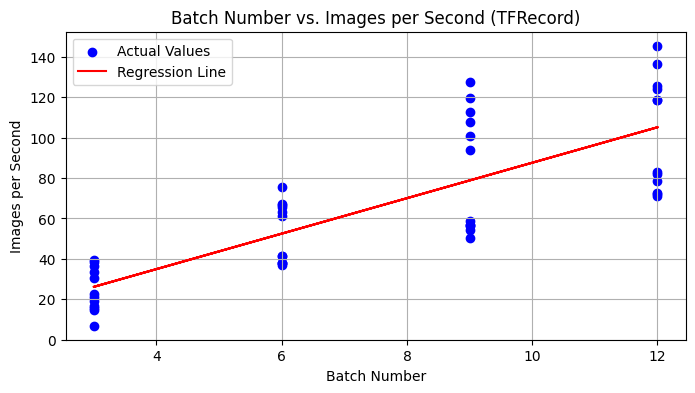

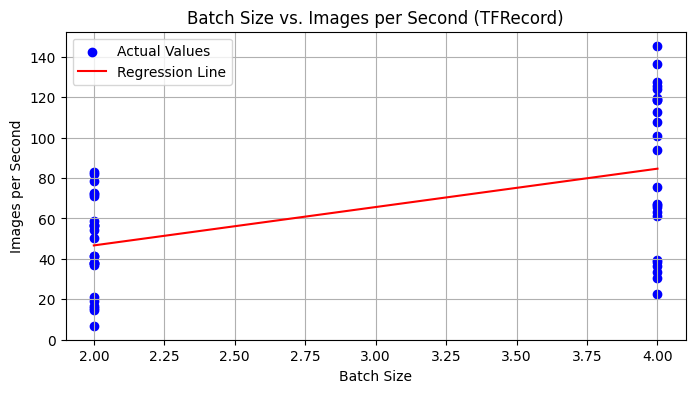

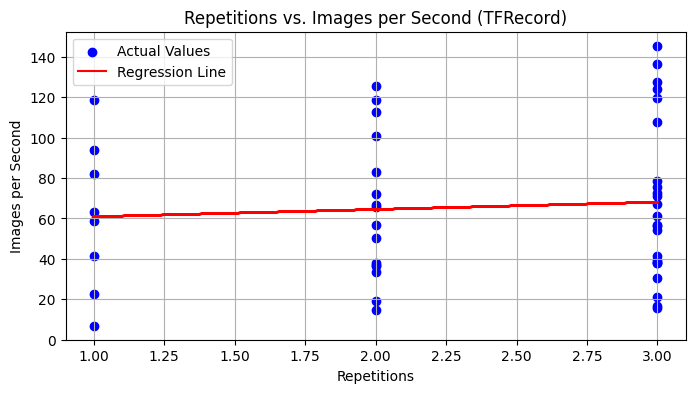

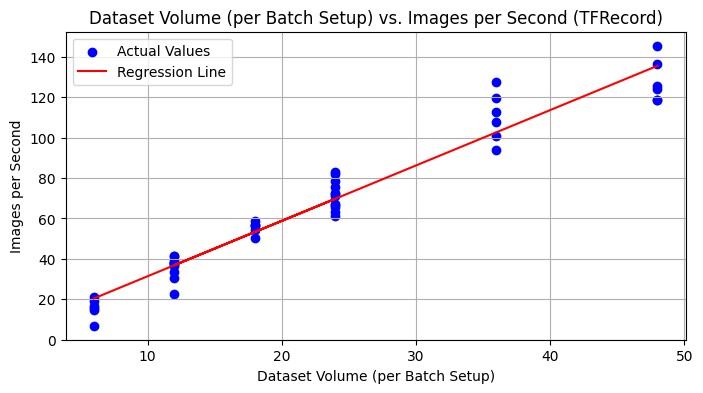

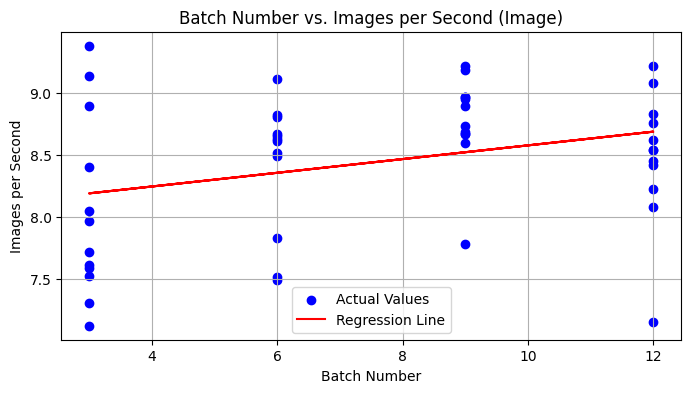

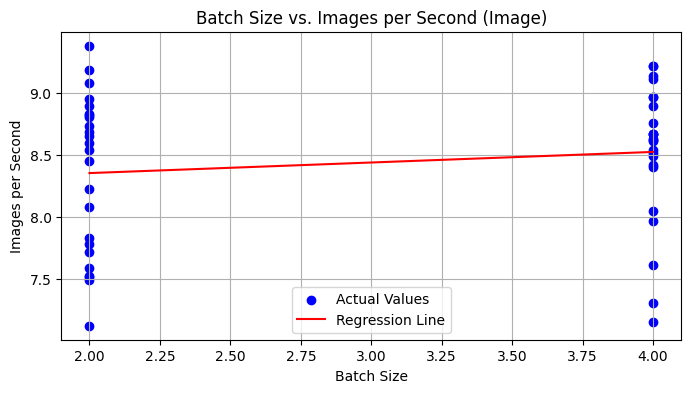

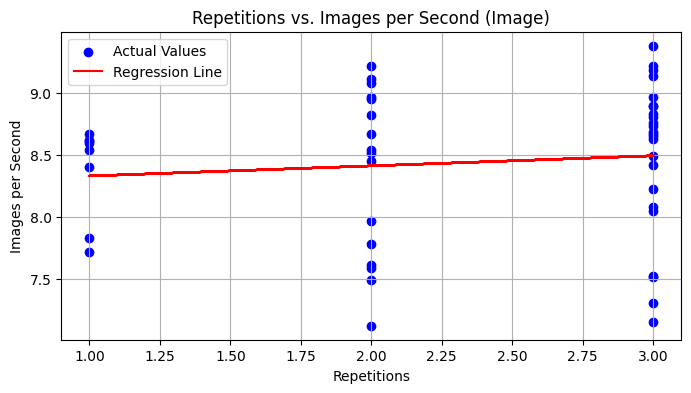

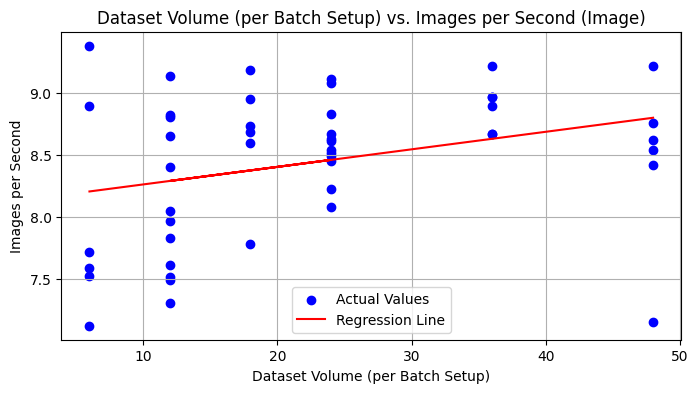

In [57]:
import pandas as pd# Importing pandas library for data manipulation.
import matplotlib.pyplot as plt# Importing matplotlib for creating visualizations and graphs.
from sklearn.linear_model import LinearRegression# Import LinearRegression for statistical modeling.

def regression_by_parameter(dataframe, dataset, parameter, title):# This function filters the dataframe, for specific features.
    filtered_data = dataframe[dataframe['Dataset'] == dataset]
    # Preparing the data for linear regression.
    X = filtered_data[[parameter]]# Independent variable.
    y = filtered_data['Images per Second']# Dependent variable.
    linear_model = LinearRegression()# Creating the linear regression model.
    linear_model.fit(X, y)# Fitting the model.
    model_predictions = linear_model.predict(X)# Predicting values based on the model.

    # Visualizing the results obtained from the model.
    plt.figure(figsize=(8,4))# Setting the figure size.
    plt.scatter(X[parameter], y, color='blue', label='Actual Values')# Plotting the actual data points.
    plt.plot(X[parameter], model_predictions, color='red', label='Regression Line')# Plotting the regression line.
    plt.title(f'{title} ({dataset})')# Title of the dataset used in the plotting.
    plt.xlabel(parameter)# Label for the x-axis.
    plt.ylabel('Images per Second')# Label for the y-axis.
    plt.legend()# Displaying the legend for the plot
    plt.grid(True)# Putting a grid to the plot.
    plt.show()# Displaying the figure.

# Defining the parameters and corresponding titles for the visualizations.
parameters = ['Batch Number', 'Batch Size', 'Repetitions', 'Dataset Volume (per Batch Setup)']
titles = ['Batch Number vs. Images per Second', 'Batch Size vs. Images per Second',
          'Repetitions vs. Images per Second', 'Dataset Volume (per Batch Setup) vs. Images per Second']

# Generating plots for the TFRecord dataset using the pre-defined parameters and titles, from above.
for parameter, title in zip(parameters, titles):
    regression_by_parameter(dataframe, 'TFRecord', parameter, title)

# Generating plots for the image dataset using the pre-defined parameters and titles, from above.
for parameter, title in zip(parameters, titles):
    regression_by_parameter(dataframe, 'Image', parameter, title)

## https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy

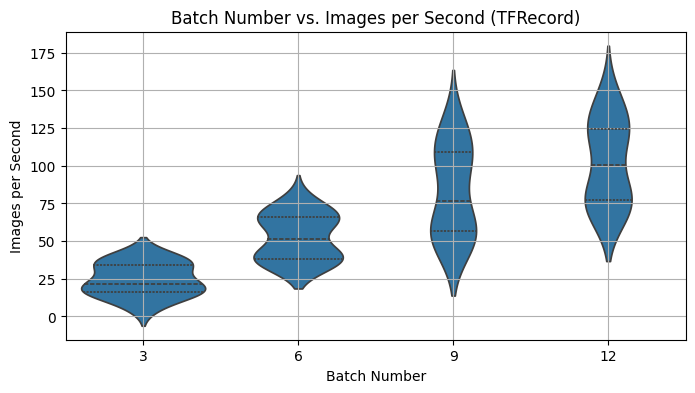

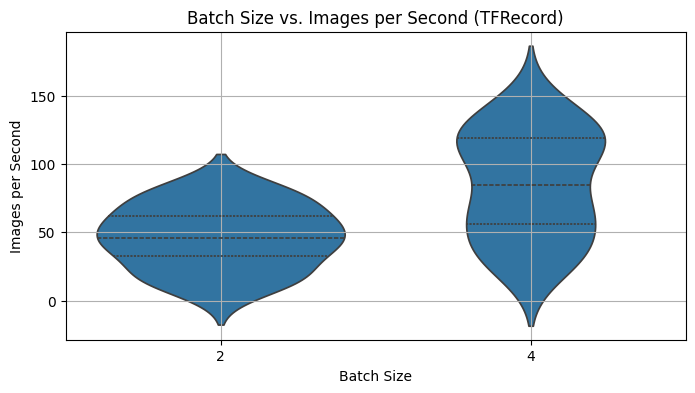

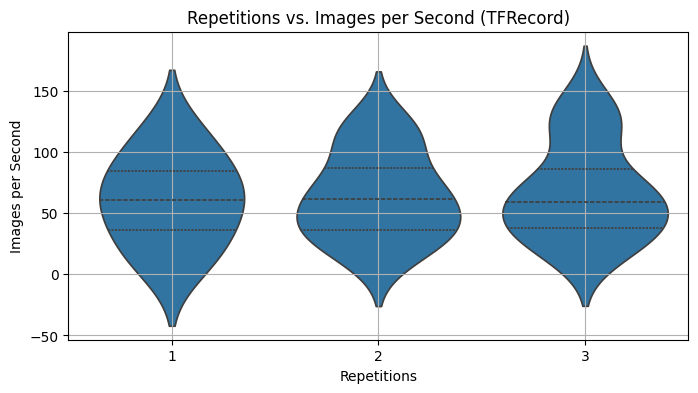

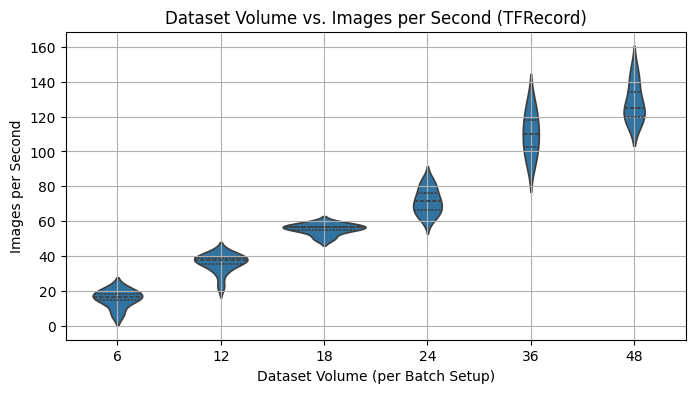

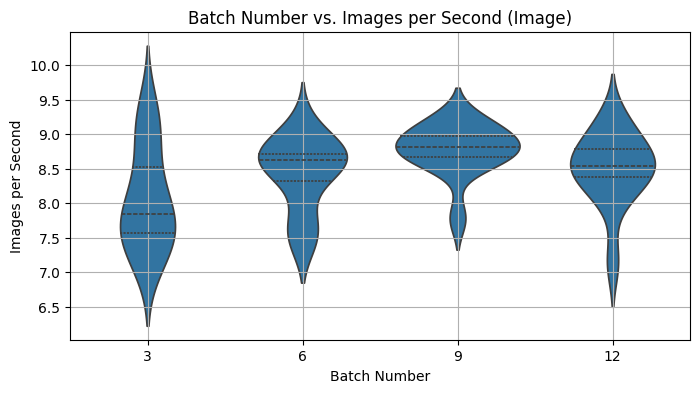

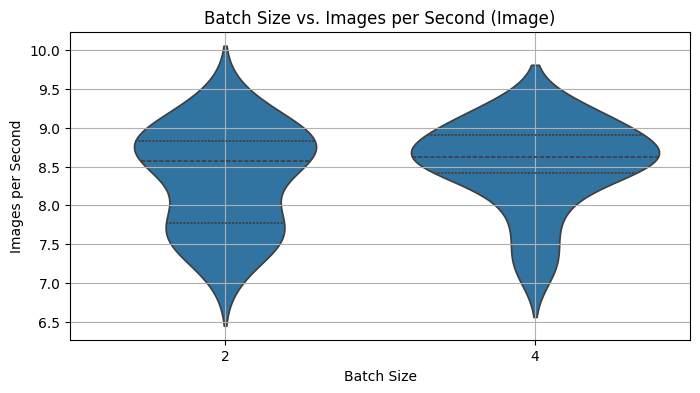

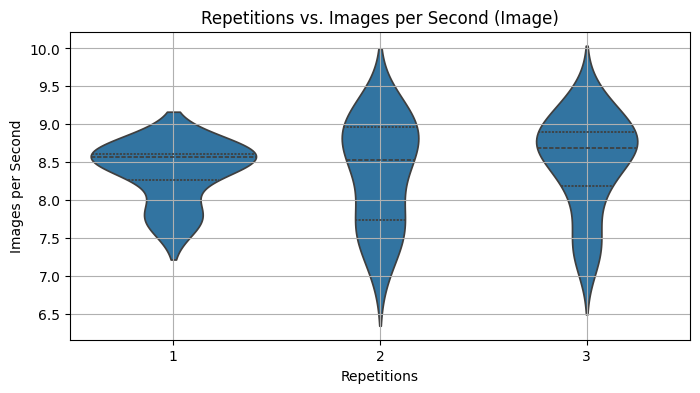

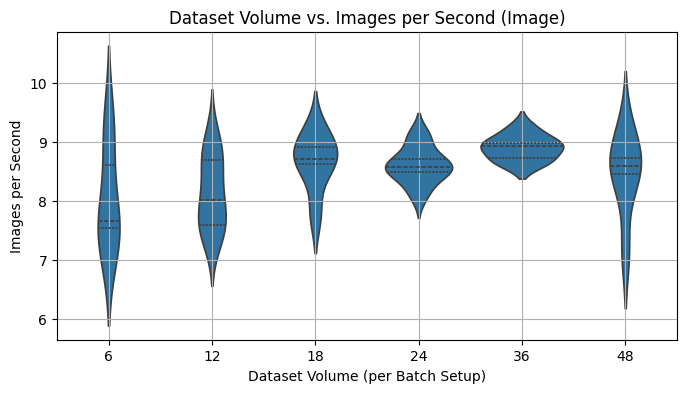

In [60]:
def plot_violin(dataframe, dataset, parameter, title):
    filtered_data = dataframe[dataframe['Dataset'] == dataset]# This function filters the dataframe, for specific features.
    plt.figure(figsize=(8, 4))# Setting the figure size.
    sns.violinplot(x=parameter, y='Images per Second', data=filtered_data, inner='quartile')# Creating the violin plots with quartiles inside the violin for the selected dataset and parameter.
    plt.xlabel(parameter)# Label for the x-axis.
    plt.ylabel('Images per Second')# Label for the y-axis.
    plt.legend()# Displaying the legend for the plot
    plt.grid(True)# Putting a grid to the plot.
    plt.show()# Displaying the figure.

# Generating violin plots for the TFRecord dataset using the pre-defined parameters and titles, from above.
for parameter, title in zip(parameters, titles):
    plot_violin(dataframe, 'TFRecord', parameter, title)

# Generating violin plots for the image dataset using the pre-defined parameters and titles, from above.
for parameter, title in zip(parameters, titles):
    plot_violin(dataframe, 'Image', parameter, title)

## https://seaborn.pydata.org/generated/seaborn.violinplot.html

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket